In [ ]:
# ============================================
# YouTube / Reddit Sentiment Analysis
# Pré-traitement & Exploration des données (EDA)
# ============================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# --------------------------
# 1️⃣ Charger le dataset
# --------------------------
df = pd.read_csv(
    'https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv'
)

# Vérifier les premières lignes et la structure
print("Aperçu des données :")
display(df.head())
print("Dimensions du dataset :", df.shape)
print("Informations générales :")
df.info()
print("Valeurs nulles par colonne :")
print(df.isnull().sum())

# --------------------------
# 2️⃣ Nettoyage des données
# --------------------------

# Supprimer les lignes avec valeurs nulles
df.dropna(inplace=True)

# Supprimer les doublons
df.drop_duplicates(inplace=True)

# Supprimer les commentaires vides après suppression des espaces
df = df[~(df['clean_comment'].str.strip() == '')]

# Convertir tous les commentaires en minuscules
df['clean_comment'] = df['clean_comment'].str.lower()

# Supprimer espaces superflus
df['clean_comment'] = df['clean_comment'].str.strip()

# Supprimer les sauts de ligne
df['clean_comment'] = df['clean_comment'].str.replace('\n', ' ', regex=True)

# Supprimer les caractères non anglais (laisser lettres, chiffres, ponctuation standard)
df['clean_comment'] = df['clean_comment'].apply(lambda x: re.sub(r'[^A-Za-z0-9\s!?.,]', '', str(x)))

# --------------------------
# 3️⃣ Analyse exploratoire (EDA)
# --------------------------

# Distribution des catégories de sentiments
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='category')
plt.title("Distribution des catégories de sentiments")
plt.show()

# Nombre de mots par commentaire
df['word_count'] = df['clean_comment'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
sns.histplot(df['word_count'], kde=True)
plt.title("Distribution du nombre de mots par commentaire")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.show()

# KDE par catégorie
plt.figure(figsize=(10,6))
sns.kdeplot(df[df['category'] == 1]['word_count'], label='Positive', fill=True)
sns.kdeplot(df[df['category'] == 0]['word_count'], label='Neutral', fill=True)
sns.kdeplot(df[df['category'] == -1]['word_count'], label='Negative', fill=True)
plt.title("Distribution du nombre de mots par catégorie")
plt.xlabel("Nombre de mots")
plt.ylabel("Densité")
plt.legend()
plt.show()

# Boxplot nombre de mots par catégorie
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='category', y='word_count')
plt.title("Boxplot du nombre de mots par catégorie")
plt.show()

# Scatterplot word count vs category
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='category', y='word_count', alpha=0.5)
plt.title("Scatterplot du nombre de mots par catégorie")
plt.show()

# --------------------------
# 4️⃣ Analyse des stopwords
# --------------------------
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}

# Compter le nombre de stopwords dans chaque commentaire
df['num_stop_words'] = df['clean_comment'].apply(
    lambda x: len([word for word in x.split() if word in stop_words])
)

# Distribution stop words
plt.figure(figsize=(10,6))
sns.histplot(df['num_stop_words'], kde=True)
plt.title("Distribution du nombre de stop words")
plt.show()

# KDE par catégorie
plt.figure(figsize=(10,6))
sns.kdeplot(df[df['category'] == 1]['num_stop_words'], label='Positive', fill=True)
sns.kdeplot(df[df['category'] == 0]['num_stop_words'], label='Neutral', fill=True)
sns.kdeplot(df[df['category'] == -1]['num_stop_words'], label='Negative', fill=True)
plt.title("Distribution du nombre de stop words par catégorie")
plt.xlabel("Nombre de stop words")
plt.ylabel("Densité")
plt.legend()
plt.show()

# --------------------------
# 5️⃣ Suppression des stopwords (en gardant mots importants pour sentiment)
# --------------------------
df['clean_comment'] = df['clean_comment'].apply(
    lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words])
)

# --------------------------
# 6️⃣ Lemmatisation
# --------------------------
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

df['clean_comment'] = df['clean_comment'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
)

# --------------------------
# 7️⃣ Visualisation WordCloud
# --------------------------
def plot_word_cloud(text, title=None):
    """Affiche un WordCloud à partir d'une liste ou série de textes"""
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    if title:
        plt.title(title, fontsize=16)
    plt.show()

# WordCloud global
plot_word_cloud(df['clean_comment'], "WordCloud global des commentaires")

# WordCloud par catégorie
plot_word_cloud(df[df['category'] == 1]['clean_comment'], "WordCloud commentaires positifs")
plot_word_cloud(df[df['category'] == 0]['clean_comment'], "WordCloud commentaires neutres")
plot_word_cloud(df[df['category'] == -1]['clean_comment'], "WordCloud commentaires négatifs")

# --------------------------
# 8️⃣ Top N mots / bigrams / trigrams
# --------------------------

def get_top_ngrams(corpus, n=25, ngram_range=(2,2)):
    """Retourne les n n-grams les plus fréquents"""
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Top 25 bigrams
top_bigrams_df = pd.DataFrame(get_top_ngrams(df['clean_comment'], 25, (2,2)), columns=['bigram','count'])
plt.figure(figsize=(12,8))
sns.barplot(data=top_bigrams_df, x='count', y='bigram', palette='magma')
plt.title("Top 25 bigrams")
plt.show()

# Top 25 trigrams
top_trigrams_df = pd.DataFrame(get_top_ngrams(df['clean_comment'], 25, (3,3)), columns=['trigram','count'])
plt.figure(figsize=(12,8))
sns.barplot(data=top_trigrams_df, x='count', y='trigram', palette='coolwarm')
plt.title("Top 25 trigrams")
plt.show()

# --------------------------
# 9️⃣ Top N mots avec distribution par catégorie
# --------------------------
def plot_top_n_words_by_category(df, n=20):
    word_category_counts = {}
    for idx, row in df.iterrows():
        words = row['clean_comment'].split()
        category = row['category']
        for word in words:
            if word not in word_category_counts:
                word_category_counts[word] = {-1:0, 0:0, 1:0}
            word_category_counts[word][category] += 1

    # Top N mots
    total_counts = {w: sum(c.values()) for w,c in word_category_counts.items()}
    top_words = sorted(total_counts.items(), key=lambda x:x[1], reverse=True)[:n]
    words = [w for w,_ in top_words]
    neg_counts = [word_category_counts[w][-1] for w in words]
    neu_counts = [word_category_counts[w][0] for w in words]
    pos_counts = [word_category_counts[w][1] for w in words]

    plt.figure(figsize=(12,8))
    bar_width = 0.75
    plt.barh(words, neg_counts, color='red', label='Negatif (-1)', height=bar_width)
    plt.barh(words, neu_counts, left=neg_counts, color='gray', label='Neutre (0)', height=bar_width)
    plt.barh(words, pos_counts, left=[i+j for i,j in zip(neg_counts, neu_counts)], color='green', label='Positif (1)', height=bar_width)
    plt.xlabel("Fréquence")
    plt.ylabel("Mots")
    plt.title(f"Top {n} mots avec répartition par catégorie")
    plt.legend(loc='lower right')
    plt.gca().invert_yaxis()
    plt.show()

plot_top_n_words_by_category(df, n=20)


In [1]:
import numpy as np
import pandas as pd

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')
df.head()

clean_comment  category
0   family mormon have never tried explain them t...         1
1  buddhism has very much lot compatible with chr...         1
2  seriously don say thing first all they won get...        -1
3  what you have learned yours and only yours wha...         0
4  for your own benefit you may want read living ...         1

In [ ]:
df.shape

(37249, 2)

In [ ]:
df.sample()['clean_comment'].values

array(['the end but crave more damn '], dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


In [ ]:
df.isnull().sum()

clean_comment    100
category           0
dtype: int64

In [ ]:
df[df['clean_comment'].isna()]

clean_comment  category
413             NaN         0
605             NaN         0
2422            NaN         0
2877            NaN         0
3307            NaN         0
...             ...       ...
35975           NaN         0
36036           NaN         0
37043           NaN         0
37111           NaN         0
37238           NaN         0

[100 rows x 2 columns]

In [ ]:
df[df['clean_comment'].isna()]['category'].value_counts()

category
0    100
Name: count, dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.duplicated().sum()

np.int64(350)

In [ ]:
df[df.duplicated()]

clean_comment  category
375                                                              0
392                                                              0
617                                           aurum mom          0
651                                                              0
1222                                                             0
...                                                  ...       ...
36915                                           who won          0
37044                                                            0
37125                                              hari          0
37158                                           top kek          1
37234  this part series minute videos focusing each d...         1

[350 rows x 2 columns]

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df[(df['clean_comment'].str.strip() == '')]

clean_comment  category
181                                   0
4432                       \n         0
10592                                 0
16173                                 0
32149  \n                             0
34959                                 0

In [ ]:
df = df[~(df['clean_comment'].str.strip() == '')]

In [ ]:
# Convert the 'clean_comment' column to lowercase
df['clean_comment'] = df['clean_comment'].str.lower()

# Verify the transformation by displaying the first few rows
df.head()


clean_comment  category
0   family mormon have never tried explain them t...         1
1  buddhism has very much lot compatible with chr...         1
2  seriously don say thing first all they won get...        -1
3  what you have learned yours and only yours wha...         0
4  for your own benefit you may want read living ...         1

In [ ]:
df[df['clean_comment'].apply(lambda x: x.endswith(' ') or x.startswith(' '))]

clean_comment  category
0       family mormon have never tried explain them t...         1
1      buddhism has very much lot compatible with chr...         1
2      seriously don say thing first all they won get...        -1
3      what you have learned yours and only yours wha...         0
4      for your own benefit you may want read living ...         1
...                                                  ...       ...
37241            let the janta decide not ulema clerics          0
37242   hona hai same with vaccination education insu...         0
37246              downvote karna tha par upvote hogaya          0
37247                                         haha nice          1
37248             facebook itself now working bjp’ cell          0

[32266 rows x 2 columns]

In [ ]:
# Remove trailing and leading whitespaces from the 'clean_comment' column
df['clean_comment'] = df['clean_comment'].str.strip()

# Verify the transformation by checking for any remaining trailing whitespaces
df['clean_comment'].apply(lambda x: x.endswith(' ') or x.startswith(' ')).sum()

np.int64(0)

In [ ]:
# Identify comments containing URLs
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
comments_with_urls = df[df['clean_comment'].str.contains(url_pattern, regex=True)]

# Display the comments containing URLs
comments_with_urls.head()


Empty DataFrame
Columns: [clean_comment, category]
Index: []

In [ ]:
# Identify comments containing new line characters
comments_with_newline = df[df['clean_comment'].str.contains('\n')]

# Display the comments containing new line characters
comments_with_newline.head()


clean_comment  category
448   what missing jpg\nand why this brilliant edit ...         1
781   india has been ruined congress and populist sc...        -1
847   like aap for its stand corruption and making p...        -1
871   reduced trade\ndeficit stronger rupee aren the...         0
1354  amsa press conference australian maritime safe...         1

In [ ]:
# Remove new line characters from the 'clean_comment' column
df['clean_comment'] = df['clean_comment'].str.replace('\n', ' ', regex=True)

# Verify the transformation by checking for any remaining new lines
comments_with_newline_remaining = df[df['clean_comment'].str.contains('\n')]
comments_with_newline_remaining


Empty DataFrame
Columns: [clean_comment, category]
Index: []

## EDA

<Axes: xlabel='category', ylabel='count'>

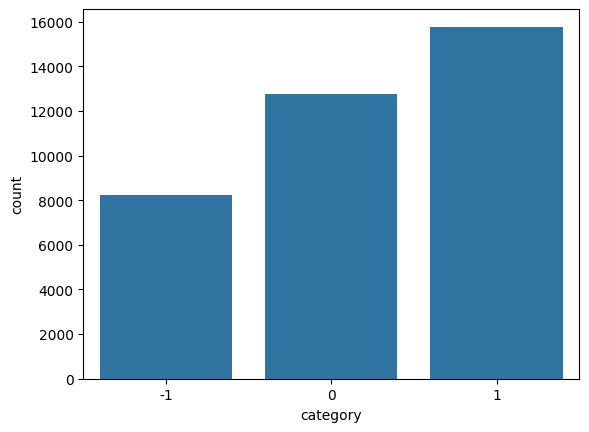

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# distribution of classes

sns.countplot(data=df,x="category")

In [ ]:
# frequency distribution of sentiments

df['category'].value_counts(normalize=True).mul(100).round(2)

category
 1    42.86
 0    34.71
-1    22.42
Name: proportion, dtype: float64

In [ ]:
df['word_count'] = df['clean_comment'].apply(lambda x: len(x.split()))

In [ ]:
df.sample(5)

clean_comment  category  word_count
5027   course there are people defending that line th...        -1         106
32114  because this journalist does not ask anything ...         1          25
23593  this will never stop unless the citizens chang...         0          12
28501  entire quora flooded with will pune affected w...         0          28
18868                              thanks for the report         1           4

In [ ]:
df['word_count'].describe()

count    36793.000000
mean        29.667464
std         56.790738
min          1.000000
25%          6.000000
50%         13.000000
75%         30.000000
max       1307.000000
Name: word_count, dtype: float64

/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)


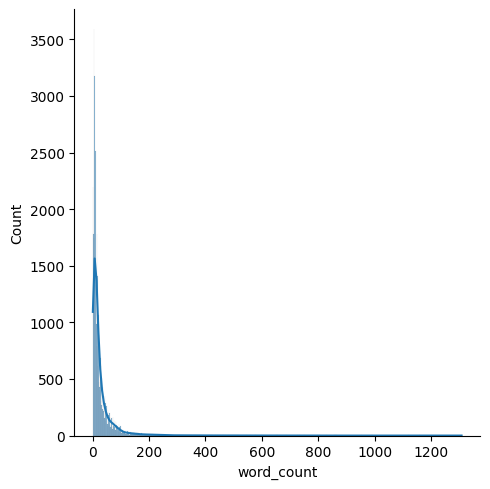

In [ ]:
sns.displot(df['word_count'], kde=True)

/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x

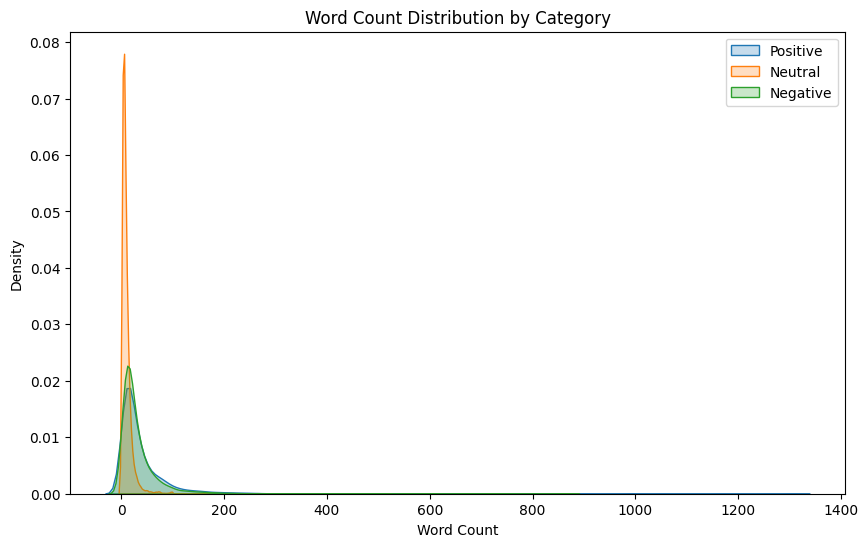

In [ ]:
# Create the figure and axes
plt.figure(figsize=(10, 6))

# Plot KDE for category 1
sns.kdeplot(df[df['category'] == 1]['word_count'], label='Positive', fill=True)

# Plot KDE for category 0
sns.kdeplot(df[df['category'] == 0]['word_count'], label='Neutral', fill=True)

# Plot KDE for category -1
sns.kdeplot(df[df['category'] == -1]['word_count'], label='Negative', fill=True)

# Add title and labels
plt.title('Word Count Distribution by Category')
plt.xlabel('Word Count')
plt.ylabel('Density')

# Add a legend
plt.legend()

# Show the plot
plt.show()

**Positive comments (category 1)**: These tend to have a wider spread in word count, indicating that longer comments are more common in positive sentiments.<br>
**Neutral comments (category 0)**: The distribution shows a relatively lower frequency and is more concentrated around shorter comments compared to positive or negative ones.<br>
**Negative comments (category -1)**: These comments have a distribution somewhat similar to positive comments but with a smaller proportion of longer comments.

<Axes: ylabel='word_count'>

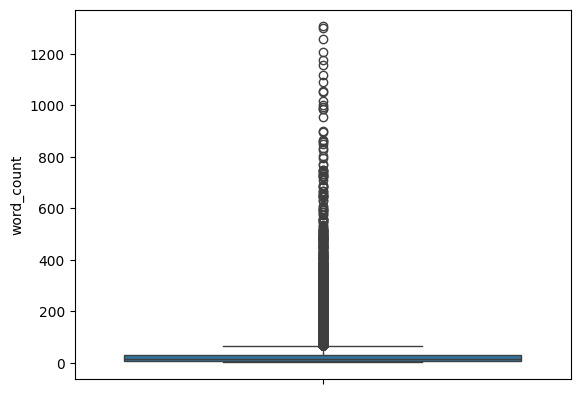

In [ ]:
sns.boxplot(df['word_count'])

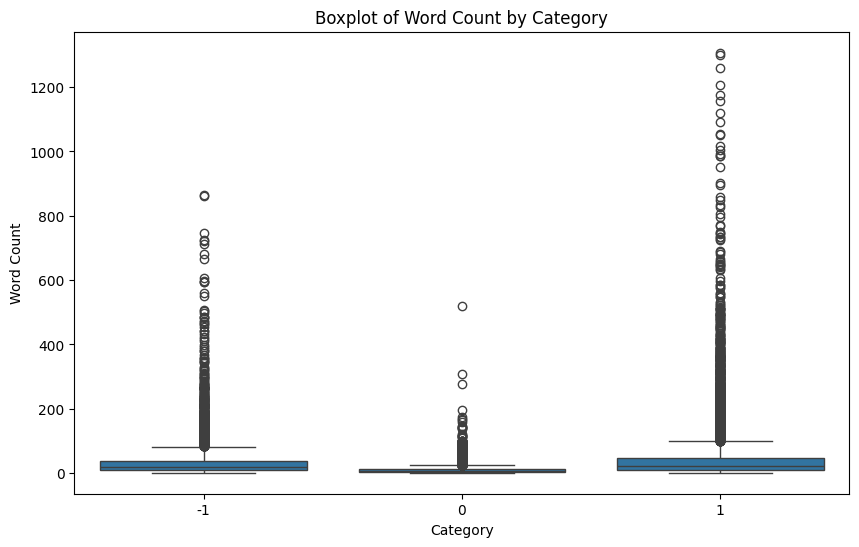

In [ ]:
# Create a boxplot for the 'wordcount' column categorized by 'category'
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='category', y='word_count')
plt.title('Boxplot of Word Count by Category')
plt.xlabel('Category')
plt.ylabel('Word Count')
plt.show()

**Positive comments (category 1)**: The median word count is relatively high, and there are several outliers with longer comments, indicating that positive comments tend to be more verbose.<br>
**Neutral comments (category 0)**: The median word count is the lowest, with a tighter interquartile range (IQR), suggesting that neutral comments are generally shorter.<br>
**Negative comments (category -1)**: The word count distribution is similar to positive comments but with a slightly lower median and fewer extreme outliers.

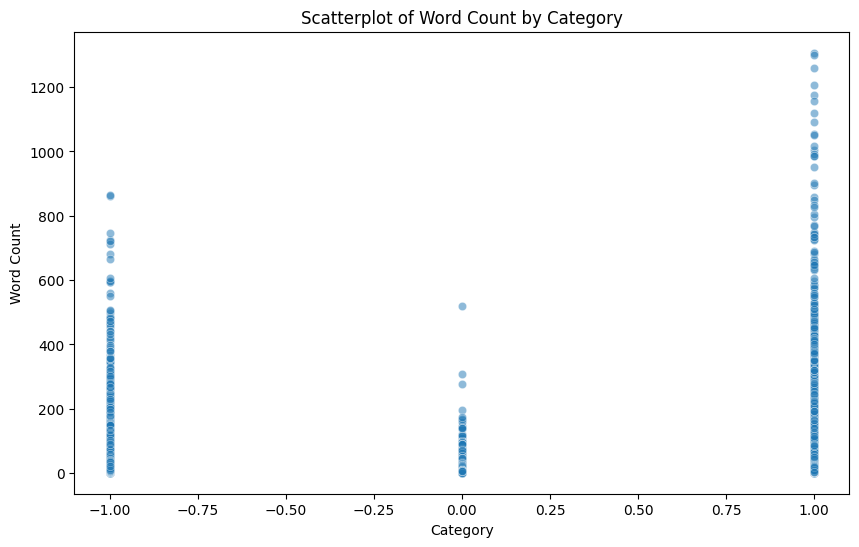

In [ ]:
# Create a scatterplot between 'category' and 'wordcount'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='category', y='word_count', alpha=0.5)
plt.title('Scatterplot of Word Count by Category')
plt.xlabel('Category')
plt.ylabel('Word Count')
plt.show()

<Axes: xlabel='category', ylabel='word_count'>

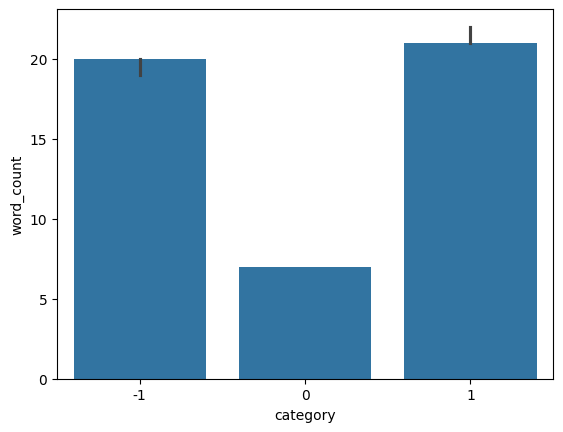

In [ ]:
# median word counts among sentiments

sns.barplot(df,x='category',y='word_count',estimator='median')

In [ ]:
!pip install nltk

In [ ]:
from nltk.corpus import stopwords

# Download NLTK stopwords if not already downloaded
import nltk
nltk.download('stopwords')

# Define the list of English stopwords
stop_words = set(stopwords.words('english'))

# Create a new column 'num_stop_words' by counting the number of stopwords in each comment
df['num_stop_words'] = df['clean_comment'].apply(lambda x: len([word for word in x.split() if word in stop_words]))


[nltk_data] Downloading package stopwords to /Users/manel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df.sample(5)

clean_comment  category  \
32329  thoughtful post which aspects you feel aren li...         1   
31458                                    copypasta sauce         0   
36719                    will destroy all kanoon dalaals        -1   
5642   wonder modi silent this brutal killing bharat ...        -1   
19526  just wanted say one bhakt friends from maheshw...         1   

       word_count  num_stop_words  
32329          12               5  
31458           2               0  
36719           5               2  
5642           17               3  
19526          60              21

/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)


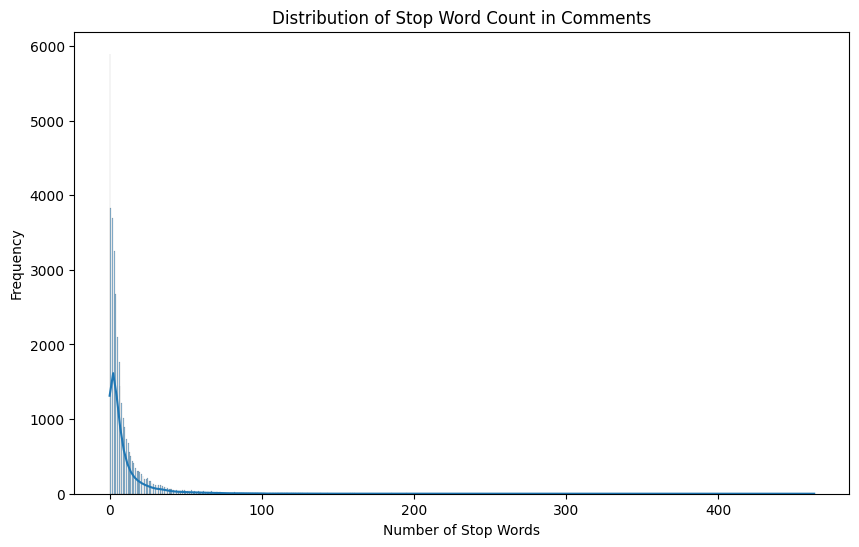

In [ ]:
# Create a distribution plot (displot) for the 'num_stop_words' column
plt.figure(figsize=(10, 6))
sns.histplot(df['num_stop_words'], kde=True)
plt.title('Distribution of Stop Word Count in Comments')
plt.xlabel('Number of Stop Words')
plt.ylabel('Frequency')
plt.show()


/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x

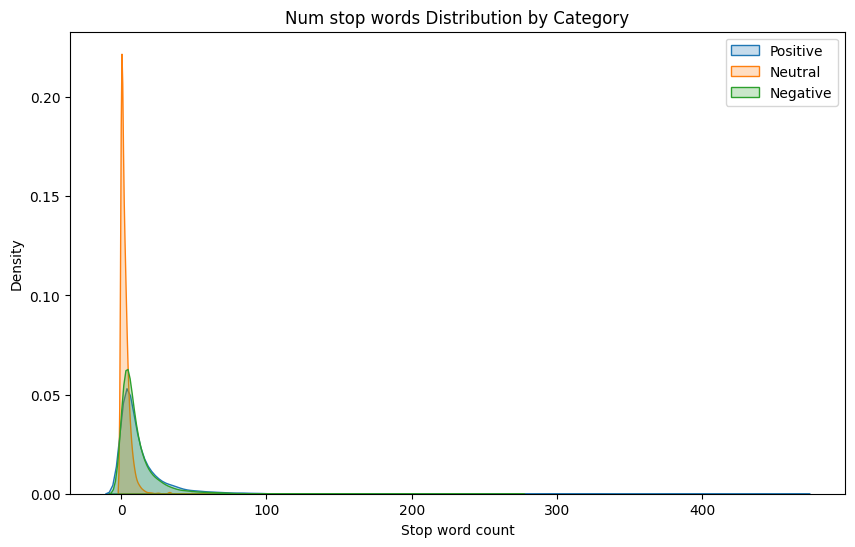

In [ ]:
# Create the figure and axes
plt.figure(figsize=(10, 6))

# Plot KDE for category 1
sns.kdeplot(df[df['category'] == 1]['num_stop_words'], label='Positive', fill=True)

# Plot KDE for category 0
sns.kdeplot(df[df['category'] == 0]['num_stop_words'], label='Neutral', fill=True)

# Plot KDE for category -1
sns.kdeplot(df[df['category'] == -1]['num_stop_words'], label='Negative', fill=True)

# Add title and labels
plt.title('Num stop words Distribution by Category')
plt.xlabel('Stop word count')
plt.ylabel('Density')

# Add a legend
plt.legend()

# Show the plot
plt.show()

<Axes: xlabel='category', ylabel='num_stop_words'>

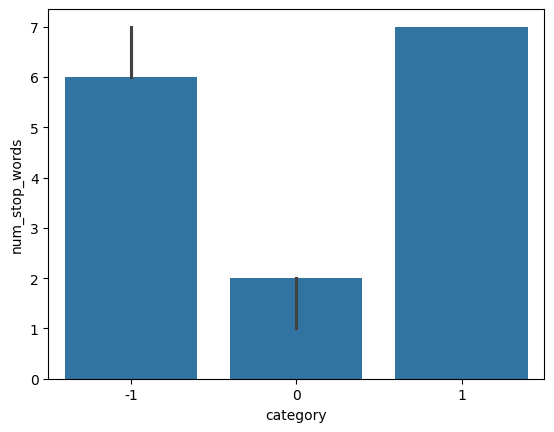

In [ ]:
# median word counts among sentiments

sns.barplot(df,x='category',y='num_stop_words',estimator='median')

/var/folders/y9/33p0s2xs1pgb2ynmxl50fyc40000gn/T/ipykernel_80837/706517223.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_df, x='count', y='stop_word', palette='viridis')


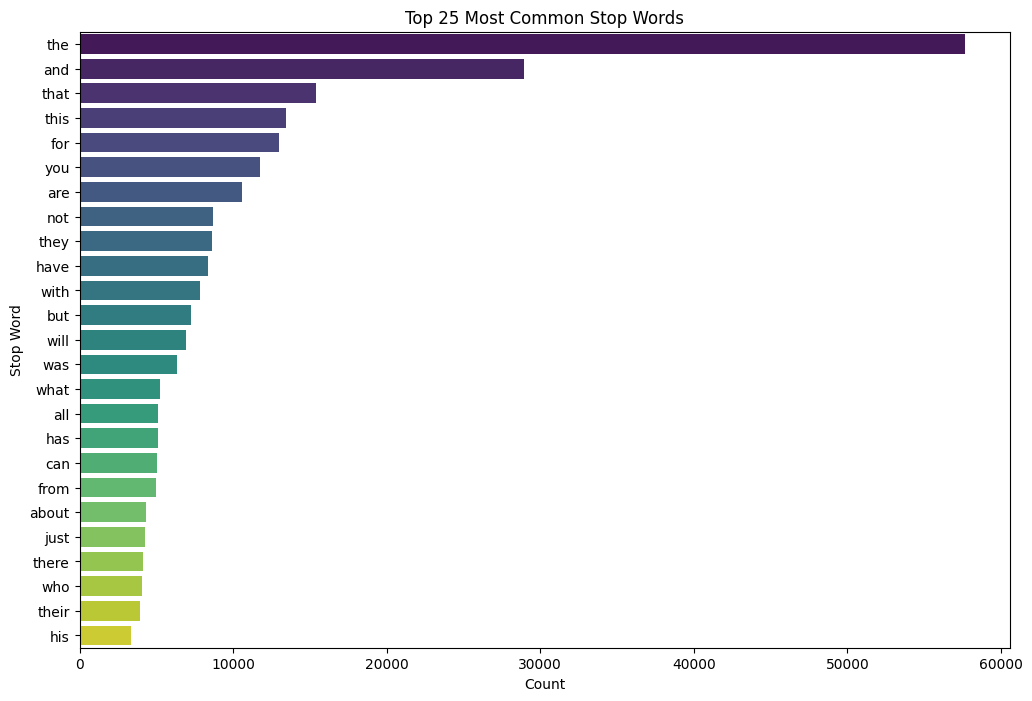

In [ ]:
# Create a frequency distribution of stop words in the 'clean_comment' column
from collections import Counter

# Extract all stop words from the comments using the previously defined 'common_stopwords'
all_stop_words = [word for comment in df['clean_comment'] for word in comment.split() if word in stop_words]

# Count the most common stop words
most_common_stop_words = Counter(all_stop_words).most_common(25)

# Convert the most common stop words to a DataFrame for plotting
top_25_df = pd.DataFrame(most_common_stop_words, columns=['stop_word', 'count'])

# Create the barplot for the top 25 most common stop words
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_df, x='count', y='stop_word', palette='viridis')
plt.title('Top 25 Most Common Stop Words')
plt.xlabel('Count')
plt.ylabel('Stop Word')
plt.show()



In [ ]:
df['num_chars'] = df['clean_comment'].apply(len)

df.head()

clean_comment  category  word_count  \
0  family mormon have never tried explain them th...         1          39   
1  buddhism has very much lot compatible with chr...         1         196   
2  seriously don say thing first all they won get...        -1          86   
3  what you have learned yours and only yours wha...         0          29   
4  for your own benefit you may want read living ...         1         112   

   num_stop_words  num_chars  
0              13        259  
1              59       1268  
2              40        459  
3              15        167  
4              45        690

In [ ]:
df['num_chars'].describe()

count    36793.000000
mean       181.852798
std        359.702163
min          1.000000
25%         38.000000
50%         80.000000
75%        184.000000
max       8664.000000
Name: num_chars, dtype: float64

In [ ]:
from collections import Counter

# Combine all comments into one large string
all_text = ' '.join(df['clean_comment'])

# Count the frequency of each character
char_frequency = Counter(all_text)

# Convert the character frequency into a DataFrame for better display
char_frequency_df = pd.DataFrame(char_frequency.items(), columns=['character', 'frequency']).sort_values(by='frequency', ascending=False)



In [ ]:
char_frequency_df['character'].values

array([' ', 'e', 't', ..., '援', '哭', '悼'], dtype=object)

In [ ]:
char_frequency_df.tail(50)

character  frequency
419          ൾ          1
973          挂          1
421          സ          1
970          荷          1
429          ശ          1
430          ൻ          1
967          满          1
965          需          1
434          œ          1
612          症          1
962          虑          1
961          考          1
960          梦          1
959          呆          1
786          示          1
992          魄          1
993          散          1
393          ◣          1
1012         丶          1
1026         龙          1
1025         将          1
635          悟          1
1023         近          1
363          ص          1
364          ح          1
1020         雪          1
1019         随          1
1018         留          1
1017         此          1
365          ط          1
776          坚          1
1014         照          1
1013         按          1
381          ☐          1
995          理          1
383          ̄          1
1009         右          1
1008         左          1
778          取          1
1005         殴          1
1004         滴          1
779          己          1
1002         记          1
628          帮          1
1000         仇          1
999          丢          1
392          ͞          1
997          援          1
996          哭          1
1095         悼          1

In [ ]:
# Create a new column 'num_punctuation_chars' to count punctuation characters in each comment
df['num_punctuation_chars'] = df['clean_comment'].apply(
    lambda x: sum([1 for char in x if char in '.,!?;:"\'()[]{}-'])
)

df.sample(5)

clean_comment  category  \
3480                       did you factor recession 2008         0   
16122  how many bakris have you fucked you kill them ...        -1   
13938                                      the beautiful         1   
7903   omar mateen identified the gunman who killed a...         1   
7075   ravish kumar िटलर ि् ‘िटलर’ ें ीं ोा ै hitler ...         1   

       word_count  num_stop_words  num_chars  num_punctuation_chars  
3480            5               2         29                      0  
16122          19               9         97                      0  
13938           2               1         13                      0  
7903           84              21        523                      0  
7075           45              15        268                      0

In [ ]:
df['num_punctuation_chars'].describe()

count    36793.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: num_punctuation_chars, dtype: float64

/var/folders/y9/33p0s2xs1pgb2ynmxl50fyc40000gn/T/ipykernel_80837/1638384091.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_bigrams_df, x='count', y='bigram', palette='magma')


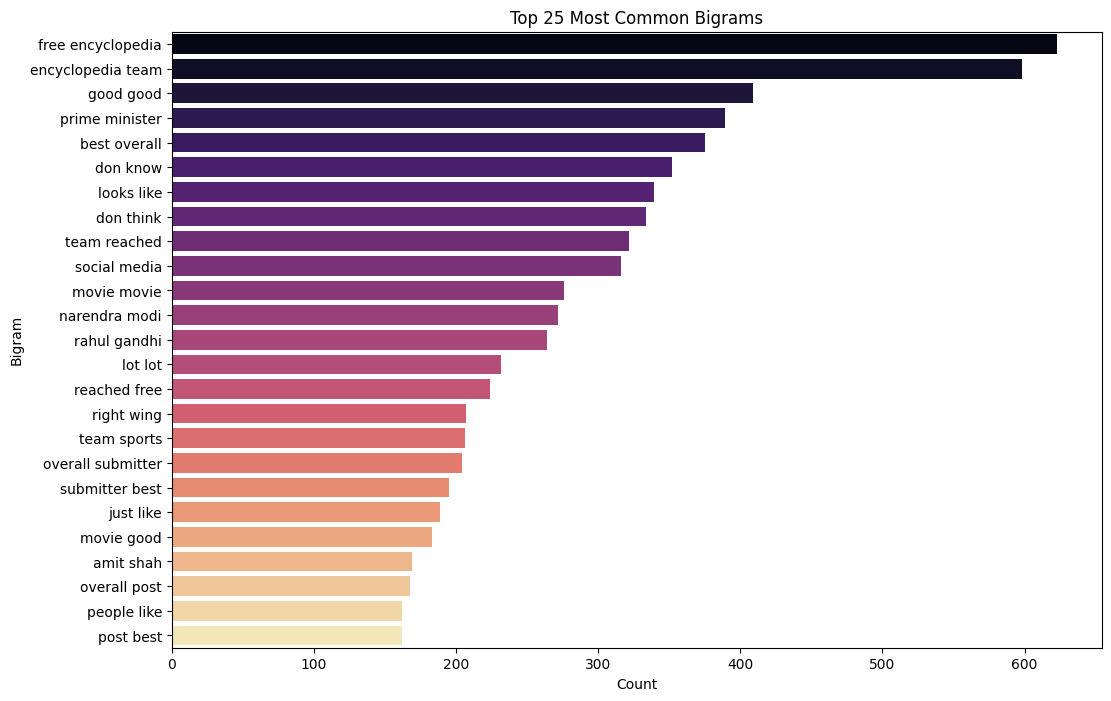

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a function to extract the top 25 bigrams
def get_top_ngrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get the top 25 bigrams
top_25_bigrams = get_top_ngrams(df['clean_comment'], 25)

# Convert the bigrams into a DataFrame for plotting
top_25_bigrams_df = pd.DataFrame(top_25_bigrams, columns=['bigram', 'count'])

# Plot the countplot for the top 25 bigrams
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_bigrams_df, x='count', y='bigram', palette='magma')
plt.title('Top 25 Most Common Bigrams')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.show()


/var/folders/y9/33p0s2xs1pgb2ynmxl50fyc40000gn/T/ipykernel_80837/2492861520.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_trigrams_df, x='count', y='trigram', palette='coolwarm')


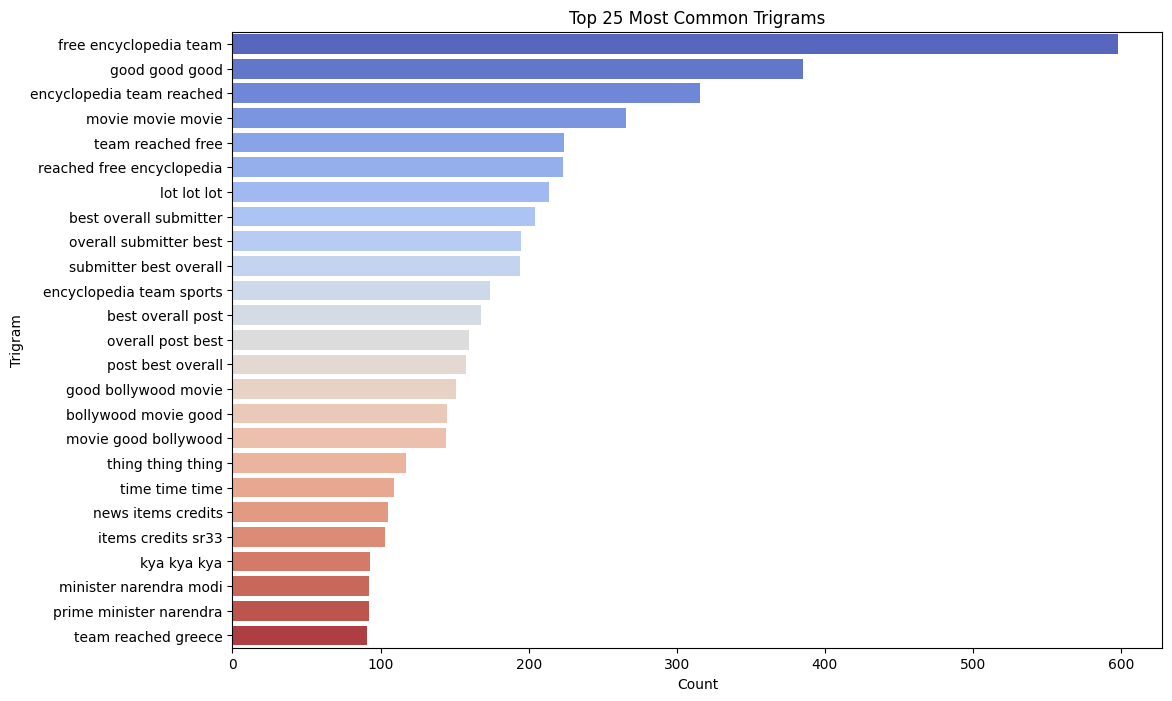

In [ ]:
# Create a function to extract the top 25 trigrams
def get_top_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get the top 25 trigrams
top_25_trigrams = get_top_trigrams(df['clean_comment'], 25)

# Convert the trigrams into a DataFrame for plotting
top_25_trigrams_df = pd.DataFrame(top_25_trigrams, columns=['trigram', 'count'])

# Plot the countplot for the top 25 trigrams
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_trigrams_df, x='count', y='trigram', palette='coolwarm')
plt.title('Top 25 Most Common Trigrams')
plt.xlabel('Count')
plt.ylabel('Trigram')
plt.show()

In [ ]:
# Remove non-English characters from the 'clean_comment' column
# Keeping only standard English letters, digits, and common punctuation
import re

df['clean_comment'] = df['clean_comment'].apply(lambda x: re.sub(r'[^A-Za-z0-9\s!?.,]', '', str(x)))


In [ ]:
all_text = ' '.join(df['clean_comment'])

# Count the frequency of each character
char_frequency = Counter(all_text)

# Convert the character frequency into a DataFrame for better display
char_frequency_df = pd.DataFrame(char_frequency.items(), columns=['character', 'frequency']).sort_values(by='frequency', ascending=False)

char_frequency_df

character  frequency
6               1091592
12         e     666610
13         t     491287
1          a     481134
3          i     401388
9          n     388465
7          o     379908
17         s     355279
8          r     331425
10         h     296748
4          l     250104
14         d     221980
18         u     170377
22         c     167821
2          m     155561
16         p     135139
21         g     132927
5          y     115420
25         w     110522
24         b      88199
0          f      78866
11         v      66020
20         k      62531
26         j      22906
15         x       9075
30         0       8477
19         z       5725
23         q       5136
31         1       4845
32         2       4638
34         9       1775
27         5       1631
35         3       1617
29         4       1573
28         6       1403
36         7       1291
33         8       1199
38                   76
37        \t         11
40                    3
39                    1

In [ ]:
df.head()

clean_comment  category  word_count  \
0  family mormon have never tried explain them th...         1          39   
1  buddhism has very much lot compatible with chr...         1         196   
2  seriously don say thing first all they won get...        -1          86   
3  what you have learned yours and only yours wha...         0          29   
4  for your own benefit you may want read living ...         1         112   

   num_stop_words  num_chars  num_punctuation_chars  
0              13        259                      0  
1              59       1268                      0  
2              40        459                      0  
3              15        167                      0  
4              45        690                      0

In [ ]:
from nltk.corpus import stopwords

# Defining stop words but keeping essential ones for sentiment analysis
stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}

# Remove stop words from 'clean_comment' column, retaining essential ones
df['clean_comment'] = df['clean_comment'].apply(
    lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words])
)




In [ ]:
df.head()

clean_comment  category  word_count  \
0  family mormon never tried explain still stare ...         1          39   
1  buddhism much lot compatible christianity espe...         1         196   
2  seriously say thing first get complex explain ...        -1          86   
3  learned want teach different focus goal not wr...         0          29   
4  benefit may want read living buddha living chr...         1         112   

   num_stop_words  num_chars  num_punctuation_chars  
0              13        259                      0  
1              59       1268                      0  
2              40        459                      0  
3              15        167                      0  
4              45        690                      0

In [ ]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

# Define the lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization to the 'clean_comment_no_stopwords' column
df['clean_comment'] = df['clean_comment'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
)

df.head()

[nltk_data] Downloading package wordnet to /Users/manel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


clean_comment  category  word_count  \
0  family mormon never tried explain still stare ...         1          39   
1  buddhism much lot compatible christianity espe...         1         196   
2  seriously say thing first get complex explain ...        -1          86   
3  learned want teach different focus goal not wr...         0          29   
4  benefit may want read living buddha living chr...         1         112   

   num_stop_words  num_chars  num_punctuation_chars  
0              13        259                      0  
1              59       1268                      0  
2              40        459                      0  
3              15        167                      0  
4              45        690                      0

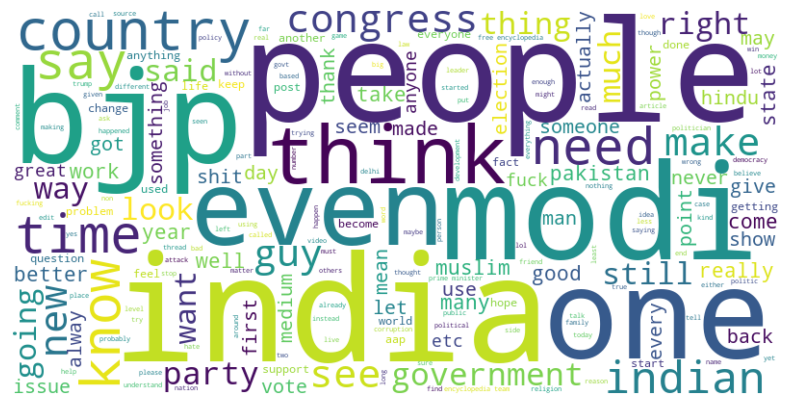

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

plot_word_cloud(df['clean_comment'])

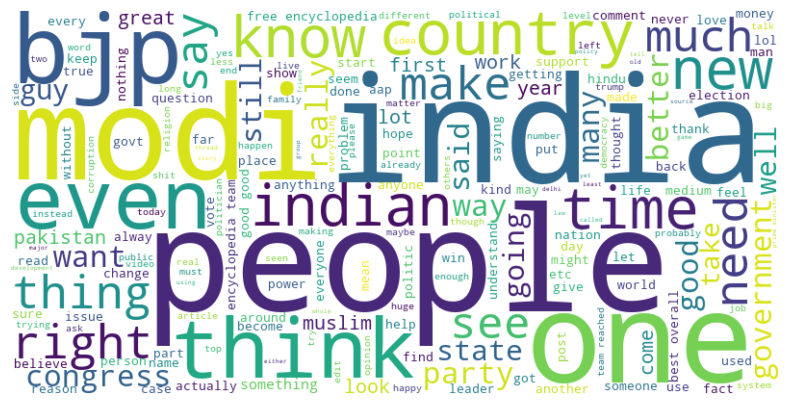

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

plot_word_cloud(df[df['category'] == 1]['clean_comment'])

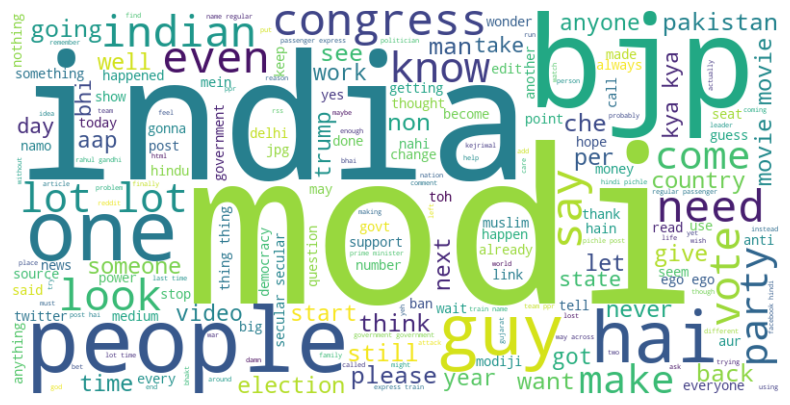

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

plot_word_cloud(df[df['category'] == 0]['clean_comment'])

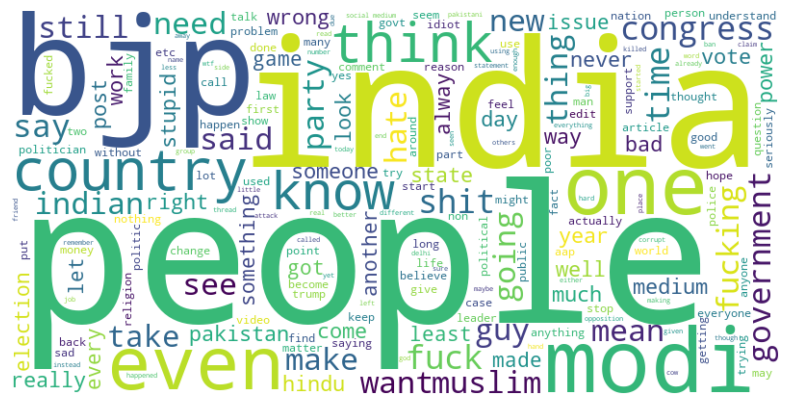

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

plot_word_cloud(df[df['category'] == -1]['clean_comment'])

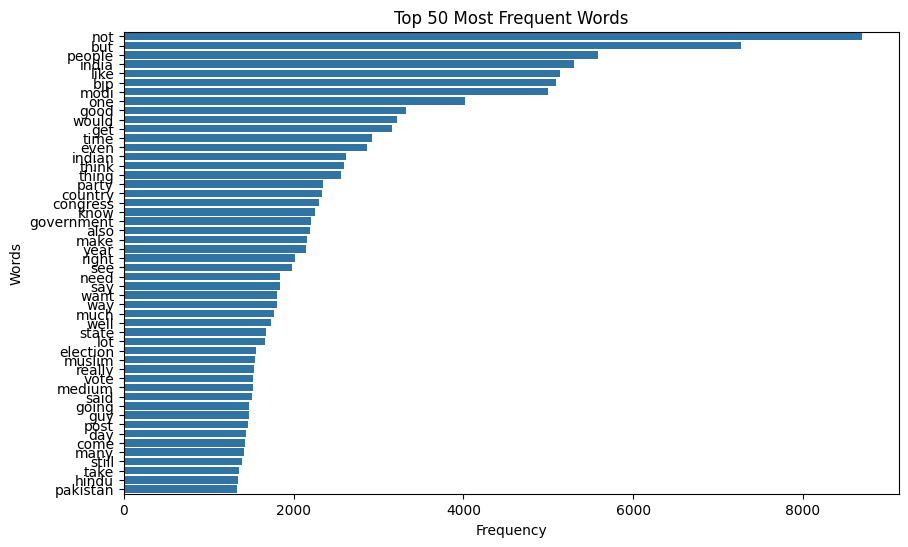

In [ ]:
def plot_top_n_words(df, n=20):
    """Plot the top N most frequent words in the dataset."""
    # Flatten all words in the content column
    words = ' '.join(df['clean_comment']).split()

    # Get the top N most common words
    counter = Counter(words)
    most_common_words = counter.most_common(n)

    # Split the words and their counts for plotting
    words, counts = zip(*most_common_words)

    # Plot the top N words
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f'Top {n} Most Frequent Words')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

# Example usage
plot_top_n_words(df, n=50)


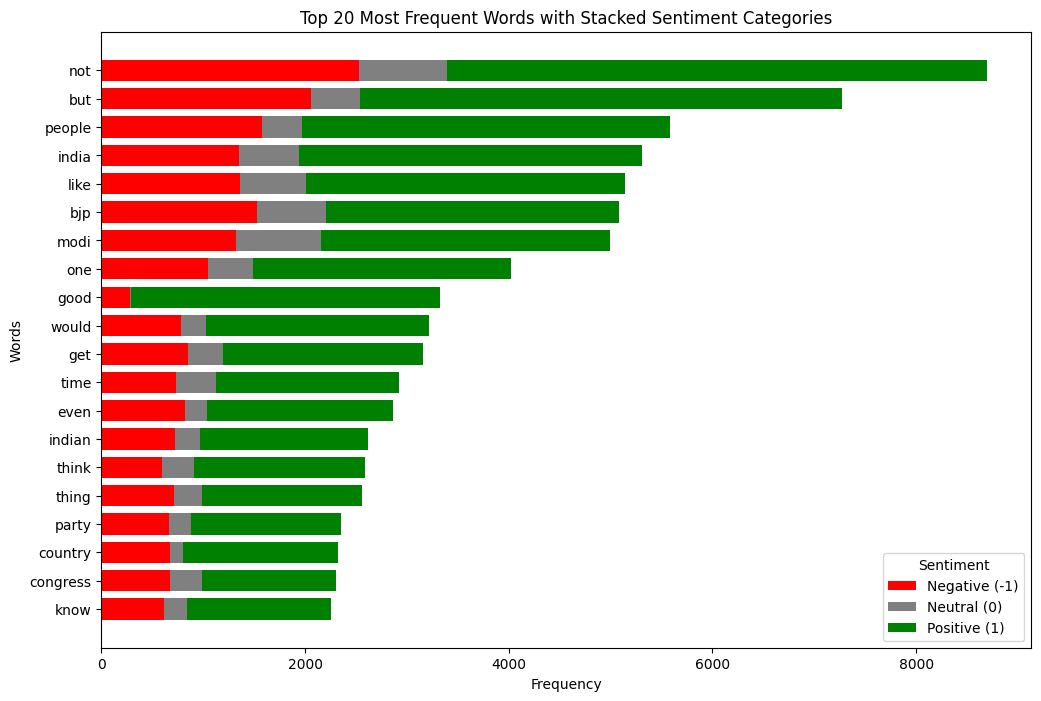

In [ ]:
def plot_top_n_words_by_category(df, n=20, start=0):
    """Plot the top N most frequent words in the dataset with stacked hue based on sentiment category."""
    # Flatten all words in the content column and count their occurrences by category
    word_category_counts = {}

    for idx, row in df.iterrows():
        words = row['clean_comment'].split()
        category = row['category']  # Assuming 'category' column exists for -1, 0, 1 labels

        for word in words:
            if word not in word_category_counts:
                word_category_counts[word] = { -1: 0, 0: 0, 1: 0 }  # Initialize counts for each sentiment category

            # Increment the count for the corresponding sentiment category
            word_category_counts[word][category] += 1

    # Get total counts across all categories for each word
    total_word_counts = {word: sum(counts.values()) for word, counts in word_category_counts.items()}

    # Get the top N most frequent words across all categories
    most_common_words = sorted(total_word_counts.items(), key=lambda x: x[1], reverse=True)[start:start+n]
    top_words = [word for word, _ in most_common_words]

    # Prepare data for plotting
    word_labels = top_words
    negative_counts = [word_category_counts[word][-1] for word in top_words]
    neutral_counts = [word_category_counts[word][0] for word in top_words]
    positive_counts = [word_category_counts[word][1] for word in top_words]

    # Plot the stacked bar chart
    plt.figure(figsize=(12, 8))
    bar_width = 0.75

    # Plot negative, neutral, and positive counts in a stacked manner
    plt.barh(word_labels, negative_counts, color='red', label='Negative (-1)', height=bar_width)
    plt.barh(word_labels, neutral_counts, left=negative_counts, color='gray', label='Neutral (0)', height=bar_width)
    plt.barh(word_labels, positive_counts, left=[i+j for i,j in zip(negative_counts, neutral_counts)], color='green', label='Positive (1)', height=bar_width)

    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top {n} Most Frequent Words with Stacked Sentiment Categories')
    plt.legend(title='Sentiment', loc='lower right')
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest frequency at the top
    plt.show()



plot_top_n_words_by_category(df, n=20)


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')
df.head()

clean_comment  category
0   family mormon have never tried explain them t...         1
1  buddhism has very much lot compatible with chr...         1
2  seriously don say thing first all they won get...        -1
3  what you have learned yours and only yours wha...         0
4  for your own benefit you may want read living ...         1

In [ ]:
df.shape

(37249, 2)

In [ ]:
df.sample()['clean_comment'].values

array(['the end but crave more damn '], dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


In [ ]:
df.isnull().sum()

clean_comment    100
category           0
dtype: int64

In [ ]:
df[df['clean_comment'].isna()]

clean_comment  category
413             NaN         0
605             NaN         0
2422            NaN         0
2877            NaN         0
3307            NaN         0
...             ...       ...
35975           NaN         0
36036           NaN         0
37043           NaN         0
37111           NaN         0
37238           NaN         0

[100 rows x 2 columns]

In [ ]:
df[df['clean_comment'].isna()]['category'].value_counts()

category
0    100
Name: count, dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.duplicated().sum()

np.int64(350)

In [ ]:
df[df.duplicated()]

clean_comment  category
375                                                              0
392                                                              0
617                                           aurum mom          0
651                                                              0
1222                                                             0
...                                                  ...       ...
36915                                           who won          0
37044                                                            0
37125                                              hari          0
37158                                           top kek          1
37234  this part series minute videos focusing each d...         1

[350 rows x 2 columns]

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df[(df['clean_comment'].str.strip() == '')]

clean_comment  category
181                                   0
4432                       \n         0
10592                                 0
16173                                 0
32149  \n                             0
34959                                 0

In [ ]:
df = df[~(df['clean_comment'].str.strip() == '')]

In [ ]:
# Convert the 'clean_comment' column to lowercase
df['clean_comment'] = df['clean_comment'].str.lower()

# Verify the transformation by displaying the first few rows
df.head()


clean_comment  category
0   family mormon have never tried explain them t...         1
1  buddhism has very much lot compatible with chr...         1
2  seriously don say thing first all they won get...        -1
3  what you have learned yours and only yours wha...         0
4  for your own benefit you may want read living ...         1

In [ ]:
df[df['clean_comment'].apply(lambda x: x.endswith(' ') or x.startswith(' '))]

clean_comment  category
0       family mormon have never tried explain them t...         1
1      buddhism has very much lot compatible with chr...         1
2      seriously don say thing first all they won get...        -1
3      what you have learned yours and only yours wha...         0
4      for your own benefit you may want read living ...         1
...                                                  ...       ...
37241            let the janta decide not ulema clerics          0
37242   hona hai same with vaccination education insu...         0
37246              downvote karna tha par upvote hogaya          0
37247                                         haha nice          1
37248             facebook itself now working bjp’ cell          0

[32266 rows x 2 columns]

In [ ]:
# Remove trailing and leading whitespaces from the 'clean_comment' column
df['clean_comment'] = df['clean_comment'].str.strip()

# Verify the transformation by checking for any remaining trailing whitespaces
df['clean_comment'].apply(lambda x: x.endswith(' ') or x.startswith(' ')).sum()

np.int64(0)

In [ ]:
# Identify comments containing URLs
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
comments_with_urls = df[df['clean_comment'].str.contains(url_pattern, regex=True)]

# Display the comments containing URLs
comments_with_urls.head()


Empty DataFrame
Columns: [clean_comment, category]
Index: []

In [ ]:
# Identify comments containing new line characters
comments_with_newline = df[df['clean_comment'].str.contains('\n')]

# Display the comments containing new line characters
comments_with_newline.head()


clean_comment  category
448   what missing jpg\nand why this brilliant edit ...         1
781   india has been ruined congress and populist sc...        -1
847   like aap for its stand corruption and making p...        -1
871   reduced trade\ndeficit stronger rupee aren the...         0
1354  amsa press conference australian maritime safe...         1

In [ ]:
# Remove new line characters from the 'clean_comment' column
df['clean_comment'] = df['clean_comment'].str.replace('\n', ' ', regex=True)

# Verify the transformation by checking for any remaining new lines
comments_with_newline_remaining = df[df['clean_comment'].str.contains('\n')]
comments_with_newline_remaining


Empty DataFrame
Columns: [clean_comment, category]
Index: []

## EDA

<Axes: xlabel='category', ylabel='count'>

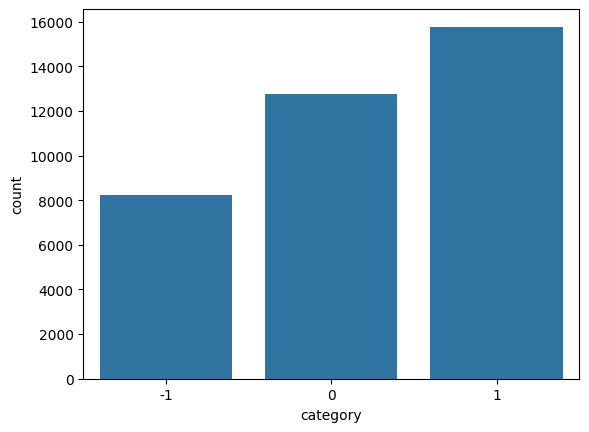

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# distribution of classes

sns.countplot(data=df,x="category")

In [ ]:
# frequency distribution of sentiments

df['category'].value_counts(normalize=True).mul(100).round(2)

category
 1    42.86
 0    34.71
-1    22.42
Name: proportion, dtype: float64

In [ ]:
df['word_count'] = df['clean_comment'].apply(lambda x: len(x.split()))

In [ ]:
df.sample(5)

clean_comment  category  word_count
5027   course there are people defending that line th...        -1         106
32114  because this journalist does not ask anything ...         1          25
23593  this will never stop unless the citizens chang...         0          12
28501  entire quora flooded with will pune affected w...         0          28
18868                              thanks for the report         1           4

In [ ]:
df['word_count'].describe()

count    36793.000000
mean        29.667464
std         56.790738
min          1.000000
25%          6.000000
50%         13.000000
75%         30.000000
max       1307.000000
Name: word_count, dtype: float64

/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)


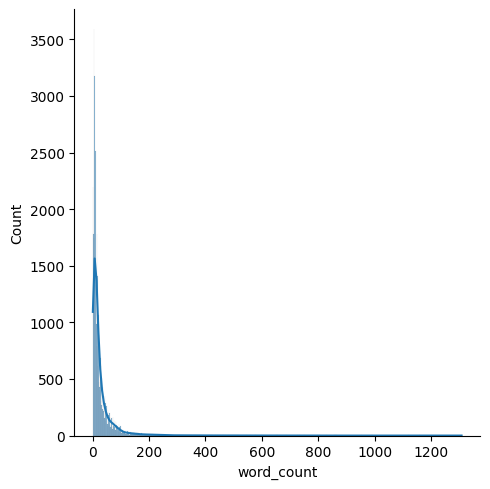

In [ ]:
sns.displot(df['word_count'], kde=True)

/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x

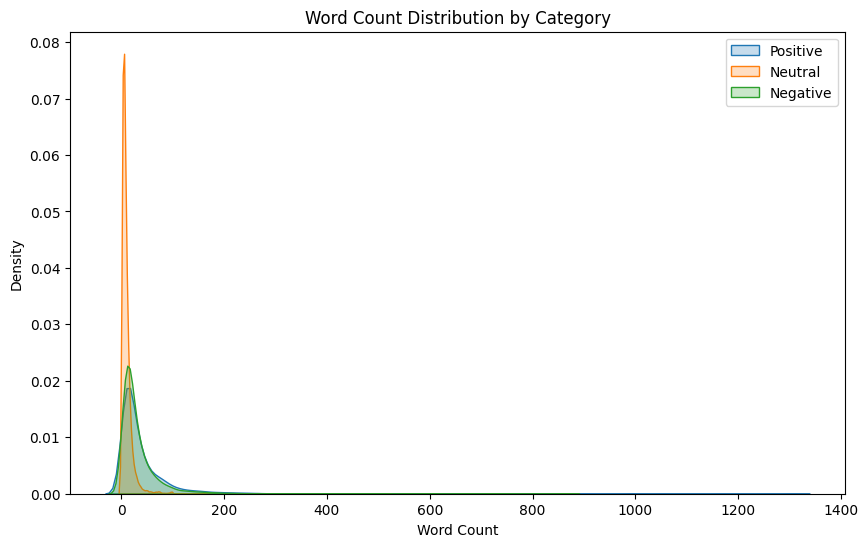

In [ ]:
# Create the figure and axes
plt.figure(figsize=(10, 6))

# Plot KDE for category 1
sns.kdeplot(df[df['category'] == 1]['word_count'], label='Positive', fill=True)

# Plot KDE for category 0
sns.kdeplot(df[df['category'] == 0]['word_count'], label='Neutral', fill=True)

# Plot KDE for category -1
sns.kdeplot(df[df['category'] == -1]['word_count'], label='Negative', fill=True)

# Add title and labels
plt.title('Word Count Distribution by Category')
plt.xlabel('Word Count')
plt.ylabel('Density')

# Add a legend
plt.legend()

# Show the plot
plt.show()

**Positive comments (category 1)**: These tend to have a wider spread in word count, indicating that longer comments are more common in positive sentiments.<br>
**Neutral comments (category 0)**: The distribution shows a relatively lower frequency and is more concentrated around shorter comments compared to positive or negative ones.<br>
**Negative comments (category -1)**: These comments have a distribution somewhat similar to positive comments but with a smaller proportion of longer comments.

<Axes: ylabel='word_count'>

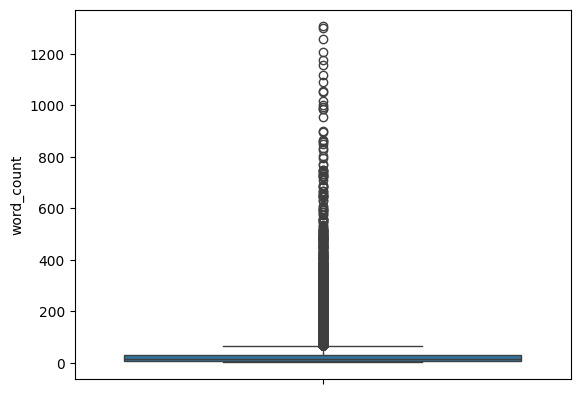

In [ ]:
sns.boxplot(df['word_count'])

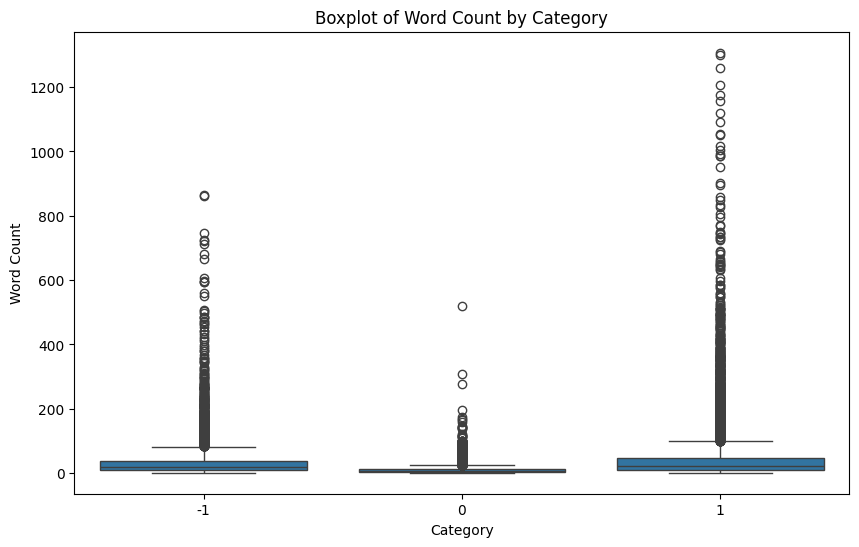

In [ ]:
# Create a boxplot for the 'wordcount' column categorized by 'category'
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='category', y='word_count')
plt.title('Boxplot of Word Count by Category')
plt.xlabel('Category')
plt.ylabel('Word Count')
plt.show()

**Positive comments (category 1)**: The median word count is relatively high, and there are several outliers with longer comments, indicating that positive comments tend to be more verbose.<br>
**Neutral comments (category 0)**: The median word count is the lowest, with a tighter interquartile range (IQR), suggesting that neutral comments are generally shorter.<br>
**Negative comments (category -1)**: The word count distribution is similar to positive comments but with a slightly lower median and fewer extreme outliers.

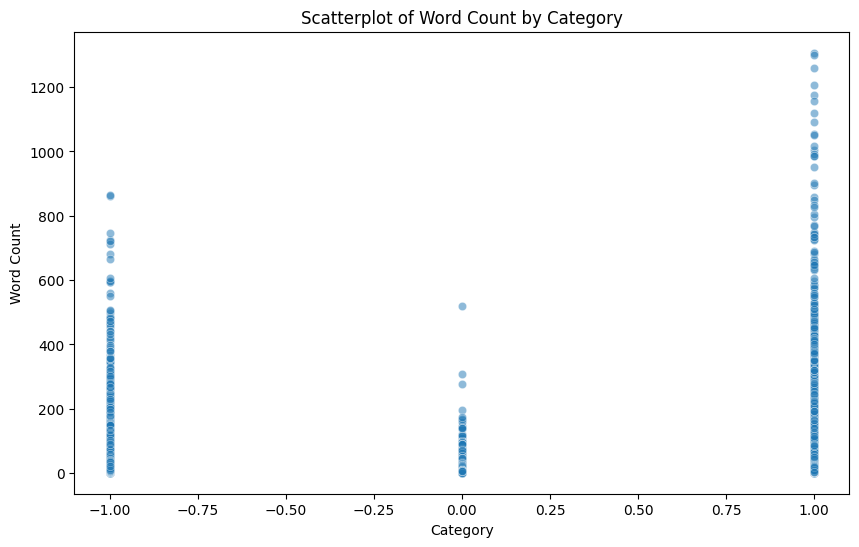

In [ ]:
# Create a scatterplot between 'category' and 'wordcount'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='category', y='word_count', alpha=0.5)
plt.title('Scatterplot of Word Count by Category')
plt.xlabel('Category')
plt.ylabel('Word Count')
plt.show()

<Axes: xlabel='category', ylabel='word_count'>

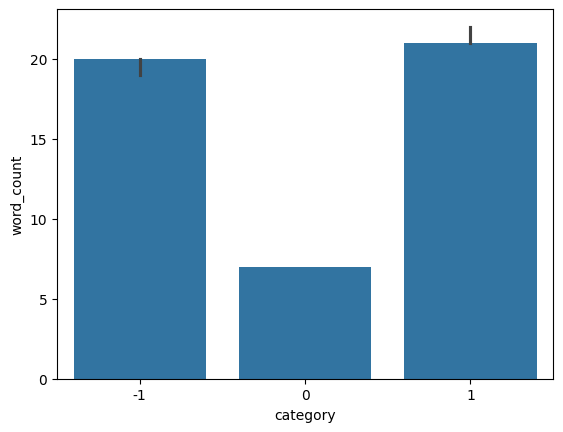

In [ ]:
# median word counts among sentiments

sns.barplot(df,x='category',y='word_count',estimator='median')

In [ ]:
!pip install nltk

In [ ]:
from nltk.corpus import stopwords

# Download NLTK stopwords if not already downloaded
import nltk
nltk.download('stopwords')

# Define the list of English stopwords
stop_words = set(stopwords.words('english'))

# Create a new column 'num_stop_words' by counting the number of stopwords in each comment
df['num_stop_words'] = df['clean_comment'].apply(lambda x: len([word for word in x.split() if word in stop_words]))


[nltk_data] Downloading package stopwords to /Users/manel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df.sample(5)

clean_comment  category  \
32329  thoughtful post which aspects you feel aren li...         1   
31458                                    copypasta sauce         0   
36719                    will destroy all kanoon dalaals        -1   
5642   wonder modi silent this brutal killing bharat ...        -1   
19526  just wanted say one bhakt friends from maheshw...         1   

       word_count  num_stop_words  
32329          12               5  
31458           2               0  
36719           5               2  
5642           17               3  
19526          60              21

/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)


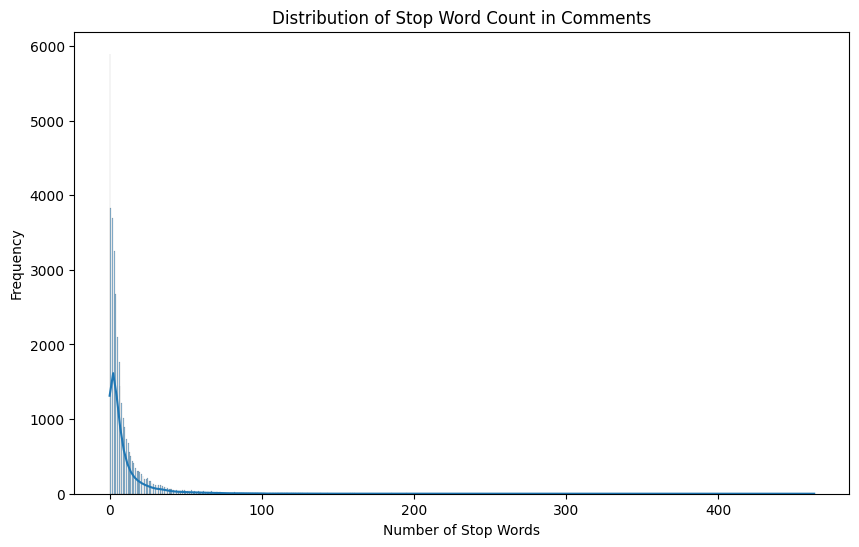

In [ ]:
# Create a distribution plot (displot) for the 'num_stop_words' column
plt.figure(figsize=(10, 6))
sns.histplot(df['num_stop_words'], kde=True)
plt.title('Distribution of Stop Word Count in Comments')
plt.xlabel('Number of Stop Words')
plt.ylabel('Frequency')
plt.show()


/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x

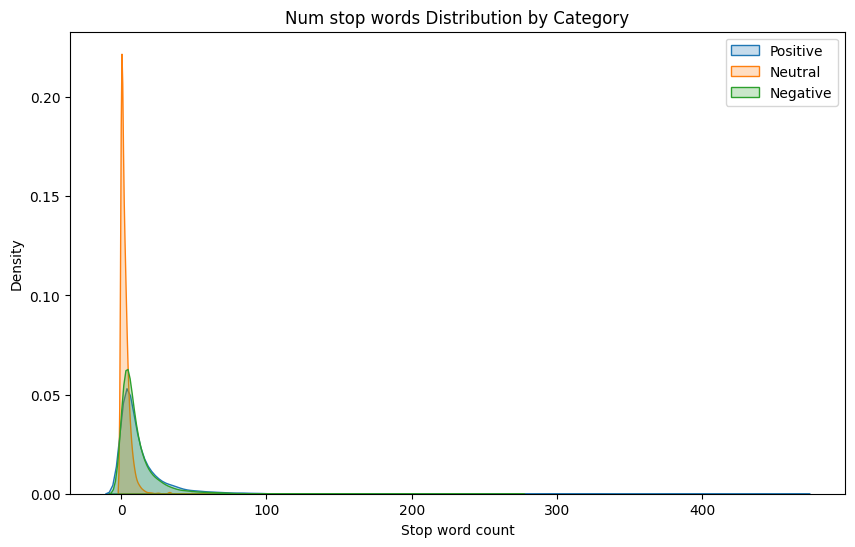

In [ ]:
# Create the figure and axes
plt.figure(figsize=(10, 6))

# Plot KDE for category 1
sns.kdeplot(df[df['category'] == 1]['num_stop_words'], label='Positive', fill=True)

# Plot KDE for category 0
sns.kdeplot(df[df['category'] == 0]['num_stop_words'], label='Neutral', fill=True)

# Plot KDE for category -1
sns.kdeplot(df[df['category'] == -1]['num_stop_words'], label='Negative', fill=True)

# Add title and labels
plt.title('Num stop words Distribution by Category')
plt.xlabel('Stop word count')
plt.ylabel('Density')

# Add a legend
plt.legend()

# Show the plot
plt.show()

<Axes: xlabel='category', ylabel='num_stop_words'>

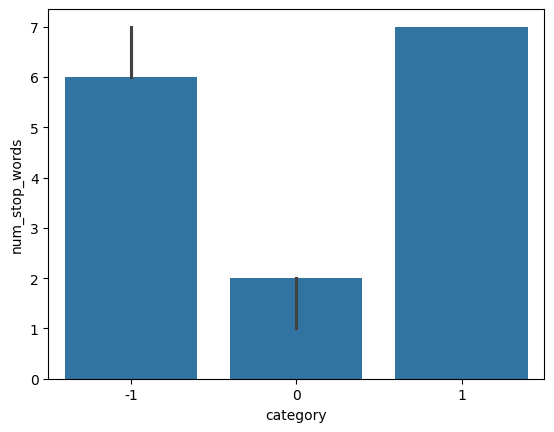

In [ ]:
# median word counts among sentiments

sns.barplot(df,x='category',y='num_stop_words',estimator='median')

/var/folders/y9/33p0s2xs1pgb2ynmxl50fyc40000gn/T/ipykernel_80837/706517223.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_df, x='count', y='stop_word', palette='viridis')


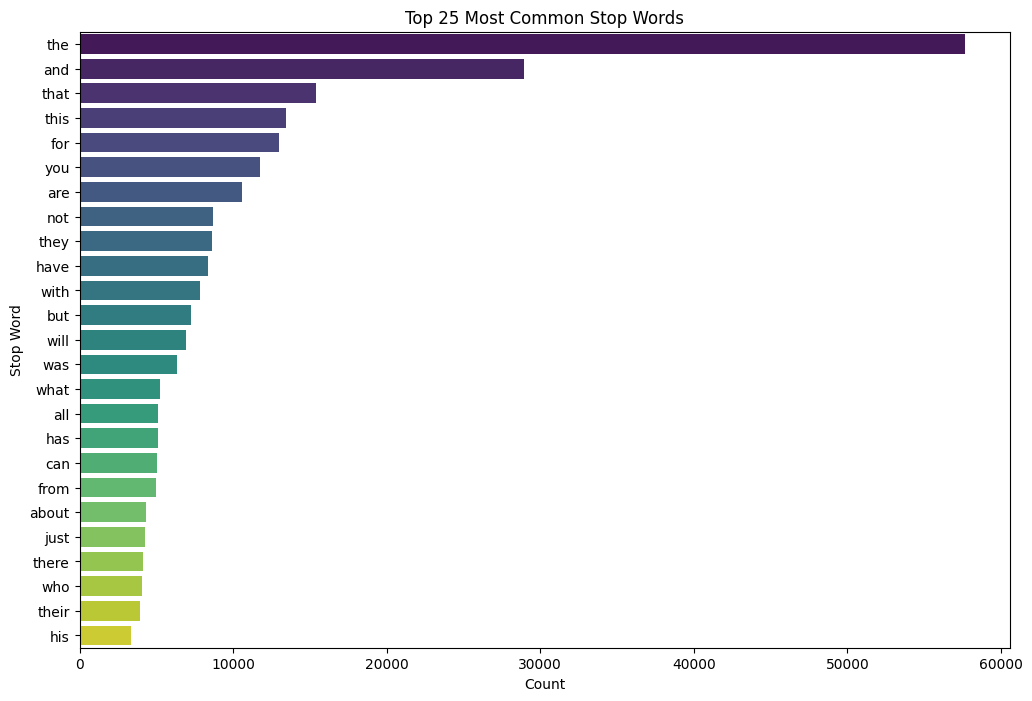

In [ ]:
# Create a frequency distribution of stop words in the 'clean_comment' column
from collections import Counter

# Extract all stop words from the comments using the previously defined 'common_stopwords'
all_stop_words = [word for comment in df['clean_comment'] for word in comment.split() if word in stop_words]

# Count the most common stop words
most_common_stop_words = Counter(all_stop_words).most_common(25)

# Convert the most common stop words to a DataFrame for plotting
top_25_df = pd.DataFrame(most_common_stop_words, columns=['stop_word', 'count'])

# Create the barplot for the top 25 most common stop words
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_df, x='count', y='stop_word', palette='viridis')
plt.title('Top 25 Most Common Stop Words')
plt.xlabel('Count')
plt.ylabel('Stop Word')
plt.show()



In [ ]:
df['num_chars'] = df['clean_comment'].apply(len)

df.head()

clean_comment  category  word_count  \
0  family mormon have never tried explain them th...         1          39   
1  buddhism has very much lot compatible with chr...         1         196   
2  seriously don say thing first all they won get...        -1          86   
3  what you have learned yours and only yours wha...         0          29   
4  for your own benefit you may want read living ...         1         112   

   num_stop_words  num_chars  
0              13        259  
1              59       1268  
2              40        459  
3              15        167  
4              45        690

In [ ]:
df['num_chars'].describe()

count    36793.000000
mean       181.852798
std        359.702163
min          1.000000
25%         38.000000
50%         80.000000
75%        184.000000
max       8664.000000
Name: num_chars, dtype: float64

In [ ]:
from collections import Counter

# Combine all comments into one large string
all_text = ' '.join(df['clean_comment'])

# Count the frequency of each character
char_frequency = Counter(all_text)

# Convert the character frequency into a DataFrame for better display
char_frequency_df = pd.DataFrame(char_frequency.items(), columns=['character', 'frequency']).sort_values(by='frequency', ascending=False)



In [ ]:
char_frequency_df['character'].values

array([' ', 'e', 't', ..., '援', '哭', '悼'], dtype=object)

In [ ]:
char_frequency_df.tail(50)

character  frequency
419          ൾ          1
973          挂          1
421          സ          1
970          荷          1
429          ശ          1
430          ൻ          1
967          满          1
965          需          1
434          œ          1
612          症          1
962          虑          1
961          考          1
960          梦          1
959          呆          1
786          示          1
992          魄          1
993          散          1
393          ◣          1
1012         丶          1
1026         龙          1
1025         将          1
635          悟          1
1023         近          1
363          ص          1
364          ح          1
1020         雪          1
1019         随          1
1018         留          1
1017         此          1
365          ط          1
776          坚          1
1014         照          1
1013         按          1
381          ☐          1
995          理          1
383          ̄          1
1009         右          1
1008         左          1
778          取          1
1005         殴          1
1004         滴          1
779          己          1
1002         记          1
628          帮          1
1000         仇          1
999          丢          1
392          ͞          1
997          援          1
996          哭          1
1095         悼          1

In [ ]:
# Create a new column 'num_punctuation_chars' to count punctuation characters in each comment
df['num_punctuation_chars'] = df['clean_comment'].apply(
    lambda x: sum([1 for char in x if char in '.,!?;:"\'()[]{}-'])
)

df.sample(5)

clean_comment  category  \
3480                       did you factor recession 2008         0   
16122  how many bakris have you fucked you kill them ...        -1   
13938                                      the beautiful         1   
7903   omar mateen identified the gunman who killed a...         1   
7075   ravish kumar िटलर ि् ‘िटलर’ ें ीं ोा ै hitler ...         1   

       word_count  num_stop_words  num_chars  num_punctuation_chars  
3480            5               2         29                      0  
16122          19               9         97                      0  
13938           2               1         13                      0  
7903           84              21        523                      0  
7075           45              15        268                      0

In [ ]:
df['num_punctuation_chars'].describe()

count    36793.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: num_punctuation_chars, dtype: float64

/var/folders/y9/33p0s2xs1pgb2ynmxl50fyc40000gn/T/ipykernel_80837/1638384091.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_bigrams_df, x='count', y='bigram', palette='magma')


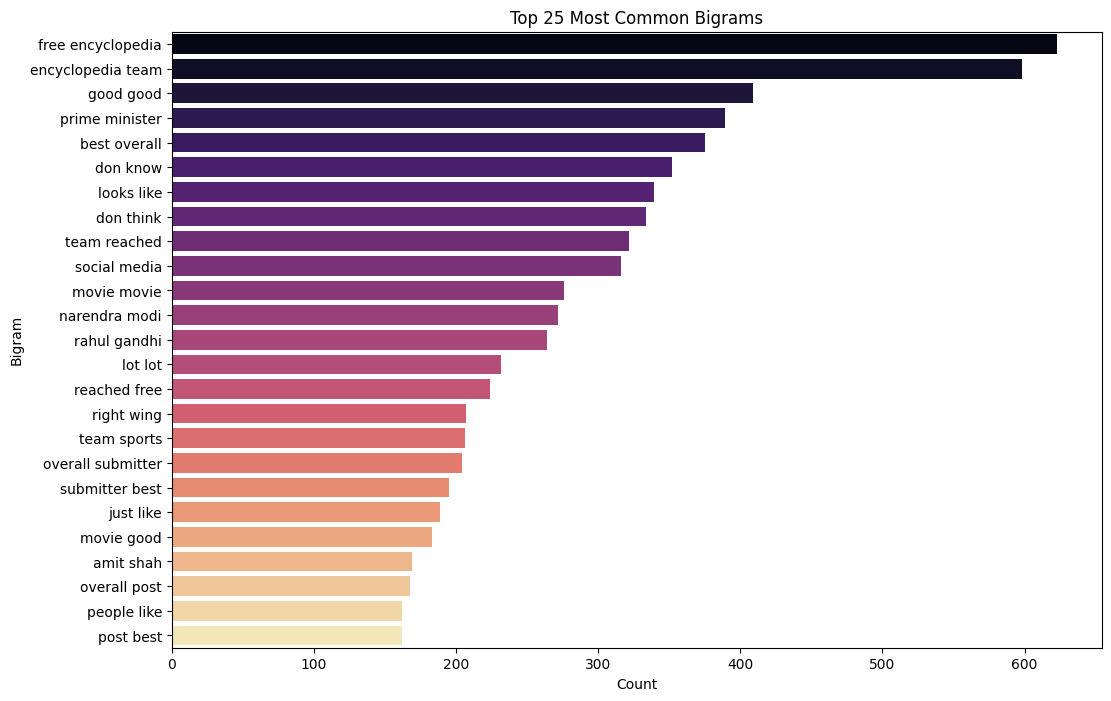

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a function to extract the top 25 bigrams
def get_top_ngrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get the top 25 bigrams
top_25_bigrams = get_top_ngrams(df['clean_comment'], 25)

# Convert the bigrams into a DataFrame for plotting
top_25_bigrams_df = pd.DataFrame(top_25_bigrams, columns=['bigram', 'count'])

# Plot the countplot for the top 25 bigrams
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_bigrams_df, x='count', y='bigram', palette='magma')
plt.title('Top 25 Most Common Bigrams')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.show()


/var/folders/y9/33p0s2xs1pgb2ynmxl50fyc40000gn/T/ipykernel_80837/2492861520.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_trigrams_df, x='count', y='trigram', palette='coolwarm')


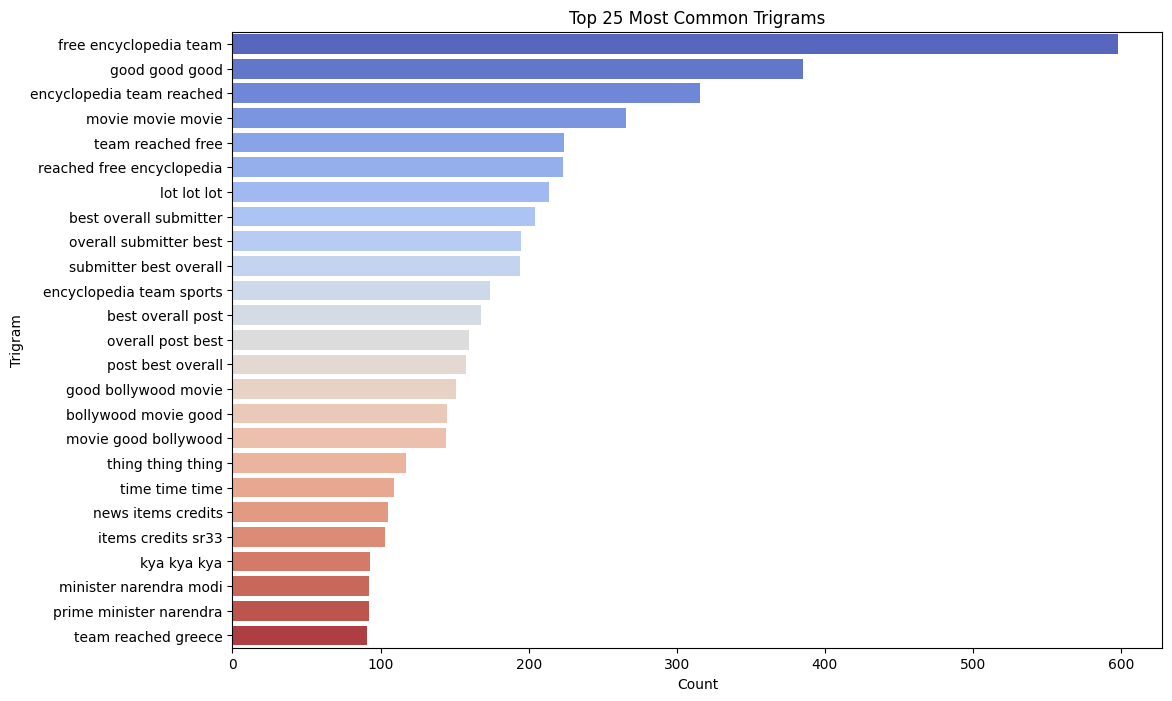

In [ ]:
# Create a function to extract the top 25 trigrams
def get_top_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get the top 25 trigrams
top_25_trigrams = get_top_trigrams(df['clean_comment'], 25)

# Convert the trigrams into a DataFrame for plotting
top_25_trigrams_df = pd.DataFrame(top_25_trigrams, columns=['trigram', 'count'])

# Plot the countplot for the top 25 trigrams
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_trigrams_df, x='count', y='trigram', palette='coolwarm')
plt.title('Top 25 Most Common Trigrams')
plt.xlabel('Count')
plt.ylabel('Trigram')
plt.show()

In [ ]:
# Remove non-English characters from the 'clean_comment' column
# Keeping only standard English letters, digits, and common punctuation
import re

df['clean_comment'] = df['clean_comment'].apply(lambda x: re.sub(r'[^A-Za-z0-9\s!?.,]', '', str(x)))


In [ ]:
all_text = ' '.join(df['clean_comment'])

# Count the frequency of each character
char_frequency = Counter(all_text)

# Convert the character frequency into a DataFrame for better display
char_frequency_df = pd.DataFrame(char_frequency.items(), columns=['character', 'frequency']).sort_values(by='frequency', ascending=False)

char_frequency_df

character  frequency
6               1091592
12         e     666610
13         t     491287
1          a     481134
3          i     401388
9          n     388465
7          o     379908
17         s     355279
8          r     331425
10         h     296748
4          l     250104
14         d     221980
18         u     170377
22         c     167821
2          m     155561
16         p     135139
21         g     132927
5          y     115420
25         w     110522
24         b      88199
0          f      78866
11         v      66020
20         k      62531
26         j      22906
15         x       9075
30         0       8477
19         z       5725
23         q       5136
31         1       4845
32         2       4638
34         9       1775
27         5       1631
35         3       1617
29         4       1573
28         6       1403
36         7       1291
33         8       1199
38                   76
37        \t         11
40                    3
39                    1

In [ ]:
df.head()

clean_comment  category  word_count  \
0  family mormon have never tried explain them th...         1          39   
1  buddhism has very much lot compatible with chr...         1         196   
2  seriously don say thing first all they won get...        -1          86   
3  what you have learned yours and only yours wha...         0          29   
4  for your own benefit you may want read living ...         1         112   

   num_stop_words  num_chars  num_punctuation_chars  
0              13        259                      0  
1              59       1268                      0  
2              40        459                      0  
3              15        167                      0  
4              45        690                      0

In [ ]:
from nltk.corpus import stopwords

# Defining stop words but keeping essential ones for sentiment analysis
stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}

# Remove stop words from 'clean_comment' column, retaining essential ones
df['clean_comment'] = df['clean_comment'].apply(
    lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words])
)




In [ ]:
df.head()

clean_comment  category  word_count  \
0  family mormon never tried explain still stare ...         1          39   
1  buddhism much lot compatible christianity espe...         1         196   
2  seriously say thing first get complex explain ...        -1          86   
3  learned want teach different focus goal not wr...         0          29   
4  benefit may want read living buddha living chr...         1         112   

   num_stop_words  num_chars  num_punctuation_chars  
0              13        259                      0  
1              59       1268                      0  
2              40        459                      0  
3              15        167                      0  
4              45        690                      0

In [ ]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

# Define the lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization to the 'clean_comment_no_stopwords' column
df['clean_comment'] = df['clean_comment'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
)

df.head()

[nltk_data] Downloading package wordnet to /Users/manel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


clean_comment  category  word_count  \
0  family mormon never tried explain still stare ...         1          39   
1  buddhism much lot compatible christianity espe...         1         196   
2  seriously say thing first get complex explain ...        -1          86   
3  learned want teach different focus goal not wr...         0          29   
4  benefit may want read living buddha living chr...         1         112   

   num_stop_words  num_chars  num_punctuation_chars  
0              13        259                      0  
1              59       1268                      0  
2              40        459                      0  
3              15        167                      0  
4              45        690                      0

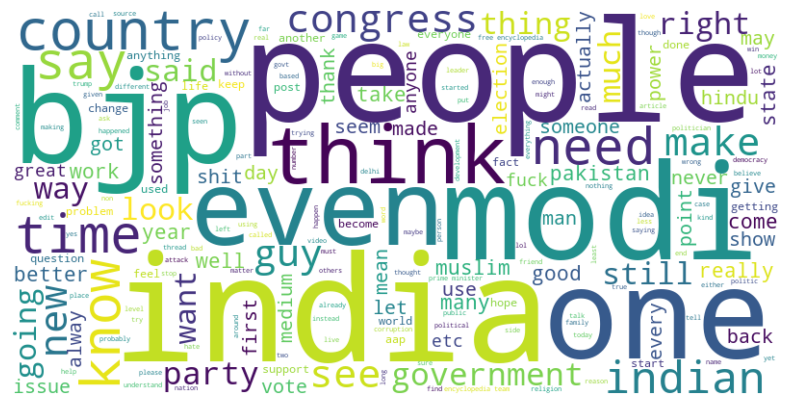

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

plot_word_cloud(df['clean_comment'])

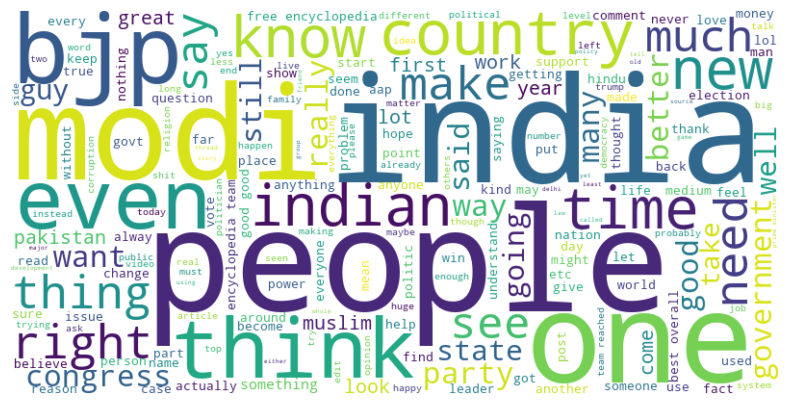

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

plot_word_cloud(df[df['category'] == 1]['clean_comment'])

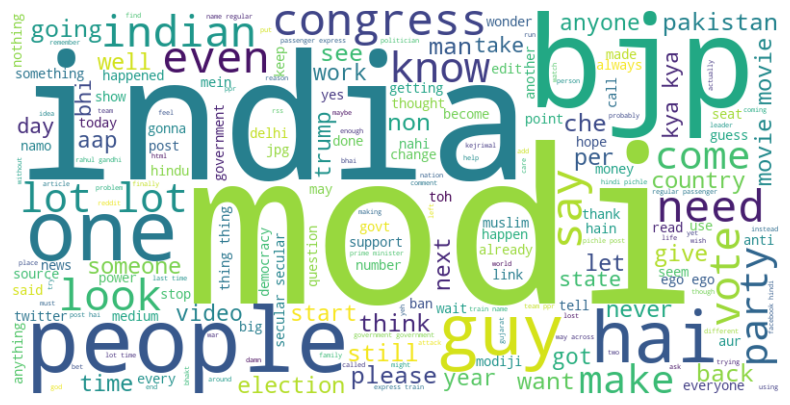

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

plot_word_cloud(df[df['category'] == 0]['clean_comment'])

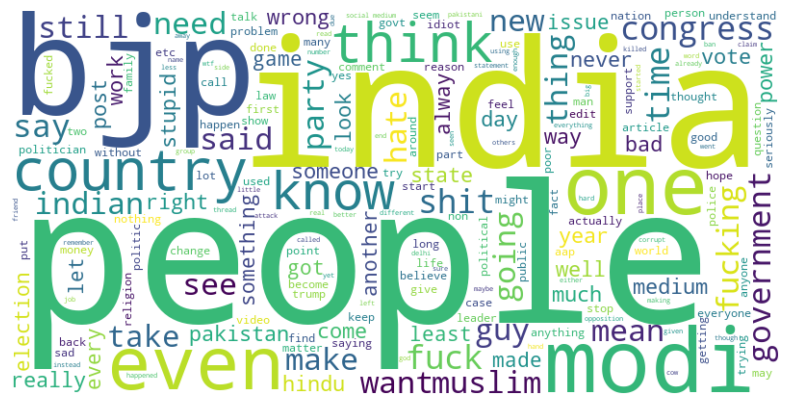

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

plot_word_cloud(df[df['category'] == -1]['clean_comment'])

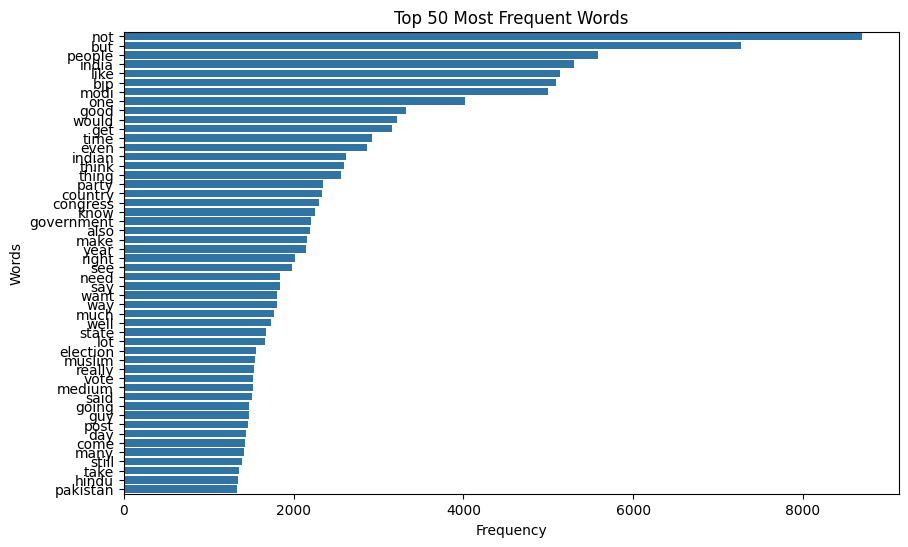

In [ ]:
def plot_top_n_words(df, n=20):
    """Plot the top N most frequent words in the dataset."""
    # Flatten all words in the content column
    words = ' '.join(df['clean_comment']).split()

    # Get the top N most common words
    counter = Counter(words)
    most_common_words = counter.most_common(n)

    # Split the words and their counts for plotting
    words, counts = zip(*most_common_words)

    # Plot the top N words
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f'Top {n} Most Frequent Words')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

# Example usage
plot_top_n_words(df, n=50)


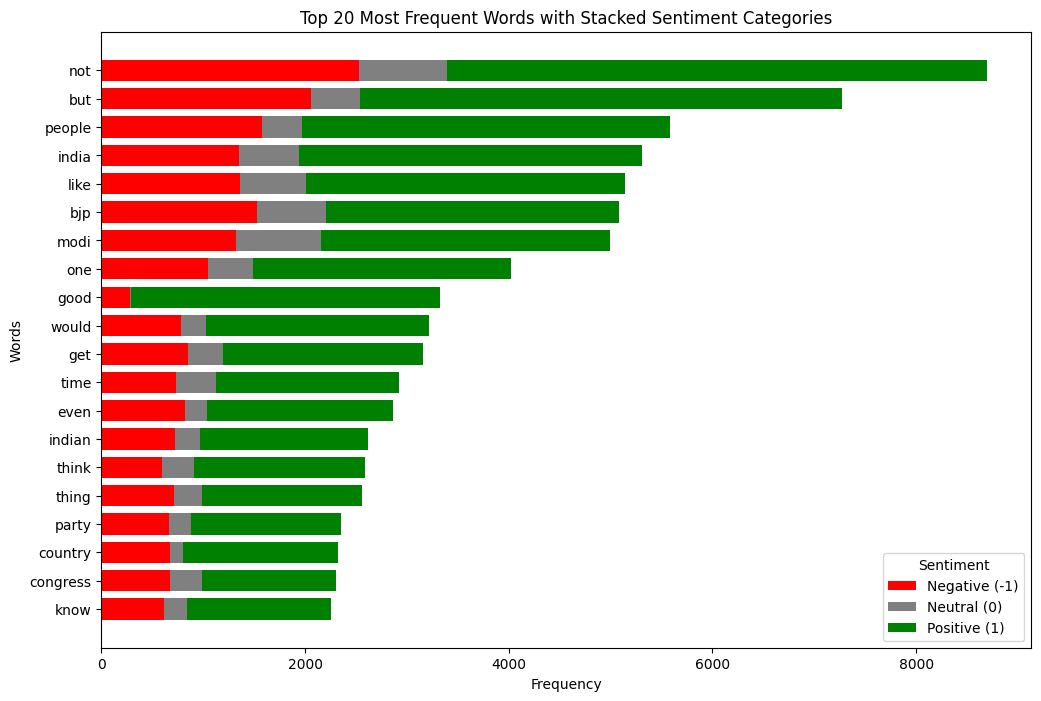

In [ ]:
def plot_top_n_words_by_category(df, n=20, start=0):
    """Plot the top N most frequent words in the dataset with stacked hue based on sentiment category."""
    # Flatten all words in the content column and count their occurrences by category
    word_category_counts = {}

    for idx, row in df.iterrows():
        words = row['clean_comment'].split()
        category = row['category']  # Assuming 'category' column exists for -1, 0, 1 labels

        for word in words:
            if word not in word_category_counts:
                word_category_counts[word] = { -1: 0, 0: 0, 1: 0 }  # Initialize counts for each sentiment category

            # Increment the count for the corresponding sentiment category
            word_category_counts[word][category] += 1

    # Get total counts across all categories for each word
    total_word_counts = {word: sum(counts.values()) for word, counts in word_category_counts.items()}

    # Get the top N most frequent words across all categories
    most_common_words = sorted(total_word_counts.items(), key=lambda x: x[1], reverse=True)[start:start+n]
    top_words = [word for word, _ in most_common_words]

    # Prepare data for plotting
    word_labels = top_words
    negative_counts = [word_category_counts[word][-1] for word in top_words]
    neutral_counts = [word_category_counts[word][0] for word in top_words]
    positive_counts = [word_category_counts[word][1] for word in top_words]

    # Plot the stacked bar chart
    plt.figure(figsize=(12, 8))
    bar_width = 0.75

    # Plot negative, neutral, and positive counts in a stacked manner
    plt.barh(word_labels, negative_counts, color='red', label='Negative (-1)', height=bar_width)
    plt.barh(word_labels, neutral_counts, left=negative_counts, color='gray', label='Neutral (0)', height=bar_width)
    plt.barh(word_labels, positive_counts, left=[i+j for i,j in zip(negative_counts, neutral_counts)], color='green', label='Positive (1)', height=bar_width)

    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top {n} Most Frequent Words with Stacked Sentiment Categories')
    plt.legend(title='Sentiment', loc='lower right')
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest frequency at the top
    plt.show()



plot_top_n_words_by_category(df, n=20)


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')
df.head()

clean_comment  category
0   family mormon have never tried explain them t...         1
1  buddhism has very much lot compatible with chr...         1
2  seriously don say thing first all they won get...        -1
3  what you have learned yours and only yours wha...         0
4  for your own benefit you may want read living ...         1

In [3]:
df.shape

(37249, 2)

In [4]:
df.sample()['clean_comment'].values

array(['the end but crave more damn '], dtype=object)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


In [6]:
df.isnull().sum()

clean_comment    100
category           0
dtype: int64

In [7]:
df[df['clean_comment'].isna()]

clean_comment  category
413             NaN         0
605             NaN         0
2422            NaN         0
2877            NaN         0
3307            NaN         0
...             ...       ...
35975           NaN         0
36036           NaN         0
37043           NaN         0
37111           NaN         0
37238           NaN         0

[100 rows x 2 columns]

In [8]:
df[df['clean_comment'].isna()]['category'].value_counts()

category
0    100
Name: count, dtype: int64

In [9]:
df.dropna(inplace=True)

In [10]:
df.duplicated().sum()

np.int64(350)

In [11]:
df[df.duplicated()]

clean_comment  category
375                                                              0
392                                                              0
617                                           aurum mom          0
651                                                              0
1222                                                             0
...                                                  ...       ...
36915                                           who won          0
37044                                                            0
37125                                              hari          0
37158                                           top kek          1
37234  this part series minute videos focusing each d...         1

[350 rows x 2 columns]

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
df.duplicated().sum()

np.int64(0)

In [14]:
df[(df['clean_comment'].str.strip() == '')]

clean_comment  category
181                                   0
4432                       \n         0
10592                                 0
16173                                 0
32149  \n                             0
34959                                 0

In [15]:
df = df[~(df['clean_comment'].str.strip() == '')]

In [16]:
# Convert the 'clean_comment' column to lowercase
df['clean_comment'] = df['clean_comment'].str.lower()

# Verify the transformation by displaying the first few rows
df.head()


clean_comment  category
0   family mormon have never tried explain them t...         1
1  buddhism has very much lot compatible with chr...         1
2  seriously don say thing first all they won get...        -1
3  what you have learned yours and only yours wha...         0
4  for your own benefit you may want read living ...         1

In [17]:
df[df['clean_comment'].apply(lambda x: x.endswith(' ') or x.startswith(' '))]

clean_comment  category
0       family mormon have never tried explain them t...         1
1      buddhism has very much lot compatible with chr...         1
2      seriously don say thing first all they won get...        -1
3      what you have learned yours and only yours wha...         0
4      for your own benefit you may want read living ...         1
...                                                  ...       ...
37241            let the janta decide not ulema clerics          0
37242   hona hai same with vaccination education insu...         0
37246              downvote karna tha par upvote hogaya          0
37247                                         haha nice          1
37248             facebook itself now working bjp’ cell          0

[32266 rows x 2 columns]

In [18]:
# Remove trailing and leading whitespaces from the 'clean_comment' column
df['clean_comment'] = df['clean_comment'].str.strip()

# Verify the transformation by checking for any remaining trailing whitespaces
df['clean_comment'].apply(lambda x: x.endswith(' ') or x.startswith(' ')).sum()

np.int64(0)

In [19]:
# Identify comments containing URLs
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
comments_with_urls = df[df['clean_comment'].str.contains(url_pattern, regex=True)]

# Display the comments containing URLs
comments_with_urls.head()


Empty DataFrame
Columns: [clean_comment, category]
Index: []

In [20]:
# Identify comments containing new line characters
comments_with_newline = df[df['clean_comment'].str.contains('\n')]

# Display the comments containing new line characters
comments_with_newline.head()


clean_comment  category
448   what missing jpg\nand why this brilliant edit ...         1
781   india has been ruined congress and populist sc...        -1
847   like aap for its stand corruption and making p...        -1
871   reduced trade\ndeficit stronger rupee aren the...         0
1354  amsa press conference australian maritime safe...         1

In [21]:
# Remove new line characters from the 'clean_comment' column
df['clean_comment'] = df['clean_comment'].str.replace('\n', ' ', regex=True)

# Verify the transformation by checking for any remaining new lines
comments_with_newline_remaining = df[df['clean_comment'].str.contains('\n')]
comments_with_newline_remaining


Empty DataFrame
Columns: [clean_comment, category]
Index: []

## EDA

<Axes: xlabel='category', ylabel='count'>

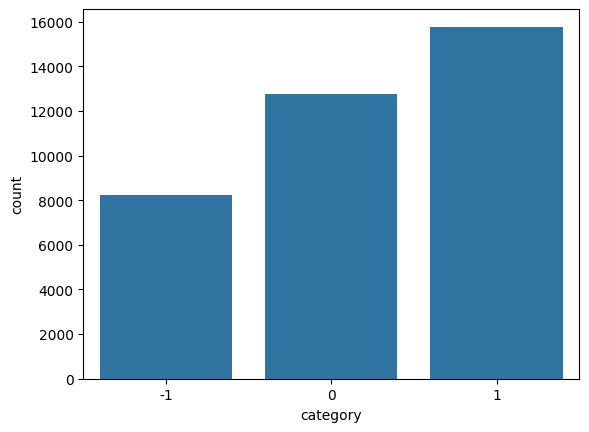

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
# distribution of classes

sns.countplot(data=df,x="category")

In [23]:
# frequency distribution of sentiments

df['category'].value_counts(normalize=True).mul(100).round(2)

category
 1    42.86
 0    34.71
-1    22.42
Name: proportion, dtype: float64

In [24]:
df['word_count'] = df['clean_comment'].apply(lambda x: len(x.split()))

In [25]:
df.sample(5)

clean_comment  category  word_count
5027   course there are people defending that line th...        -1         106
32114  because this journalist does not ask anything ...         1          25
23593  this will never stop unless the citizens chang...         0          12
28501  entire quora flooded with will pune affected w...         0          28
18868                              thanks for the report         1           4

In [26]:
df['word_count'].describe()

count    36793.000000
mean        29.667464
std         56.790738
min          1.000000
25%          6.000000
50%         13.000000
75%         30.000000
max       1307.000000
Name: word_count, dtype: float64

/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)


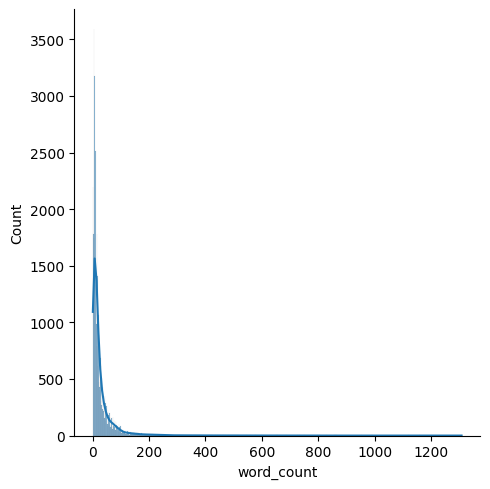

In [27]:
sns.displot(df['word_count'], kde=True)

/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x

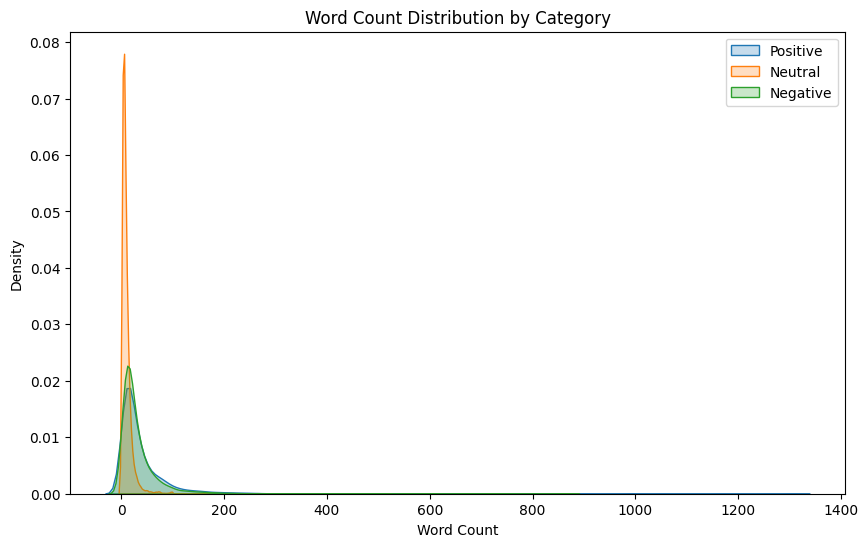

In [28]:
# Create the figure and axes
plt.figure(figsize=(10, 6))

# Plot KDE for category 1
sns.kdeplot(df[df['category'] == 1]['word_count'], label='Positive', fill=True)

# Plot KDE for category 0
sns.kdeplot(df[df['category'] == 0]['word_count'], label='Neutral', fill=True)

# Plot KDE for category -1
sns.kdeplot(df[df['category'] == -1]['word_count'], label='Negative', fill=True)

# Add title and labels
plt.title('Word Count Distribution by Category')
plt.xlabel('Word Count')
plt.ylabel('Density')

# Add a legend
plt.legend()

# Show the plot
plt.show()

**Positive comments (category 1)**: These tend to have a wider spread in word count, indicating that longer comments are more common in positive sentiments.<br>
**Neutral comments (category 0)**: The distribution shows a relatively lower frequency and is more concentrated around shorter comments compared to positive or negative ones.<br>
**Negative comments (category -1)**: These comments have a distribution somewhat similar to positive comments but with a smaller proportion of longer comments.

<Axes: ylabel='word_count'>

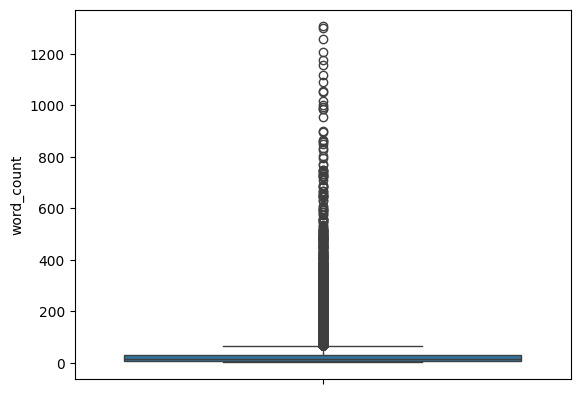

In [29]:
sns.boxplot(df['word_count'])

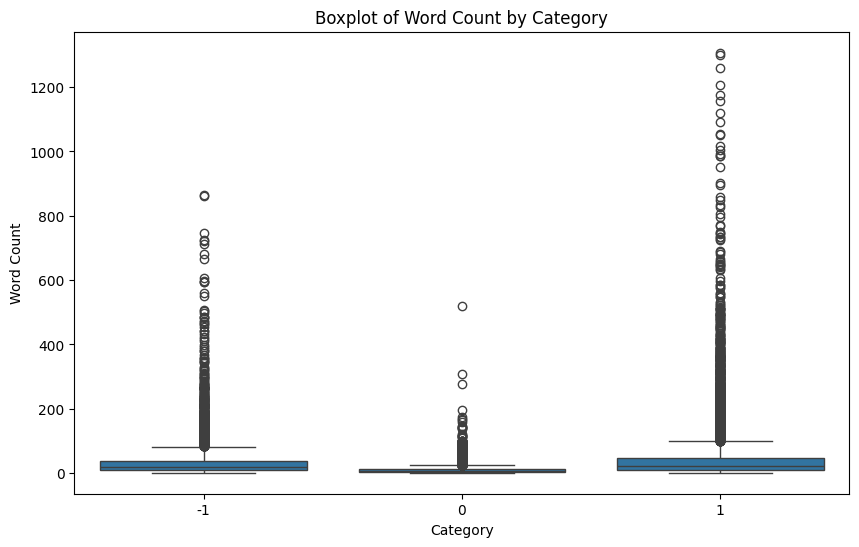

In [30]:
# Create a boxplot for the 'wordcount' column categorized by 'category'
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='category', y='word_count')
plt.title('Boxplot of Word Count by Category')
plt.xlabel('Category')
plt.ylabel('Word Count')
plt.show()

**Positive comments (category 1)**: The median word count is relatively high, and there are several outliers with longer comments, indicating that positive comments tend to be more verbose.<br>
**Neutral comments (category 0)**: The median word count is the lowest, with a tighter interquartile range (IQR), suggesting that neutral comments are generally shorter.<br>
**Negative comments (category -1)**: The word count distribution is similar to positive comments but with a slightly lower median and fewer extreme outliers.

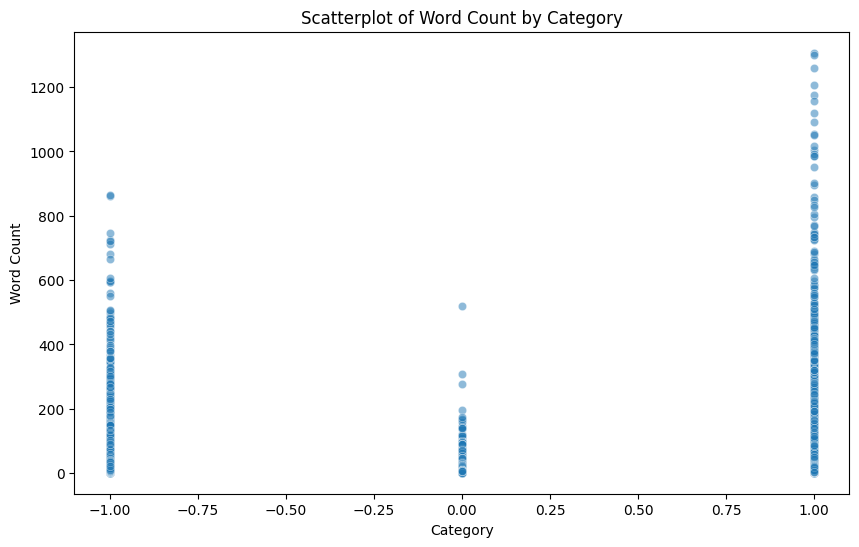

In [31]:
# Create a scatterplot between 'category' and 'wordcount'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='category', y='word_count', alpha=0.5)
plt.title('Scatterplot of Word Count by Category')
plt.xlabel('Category')
plt.ylabel('Word Count')
plt.show()

<Axes: xlabel='category', ylabel='word_count'>

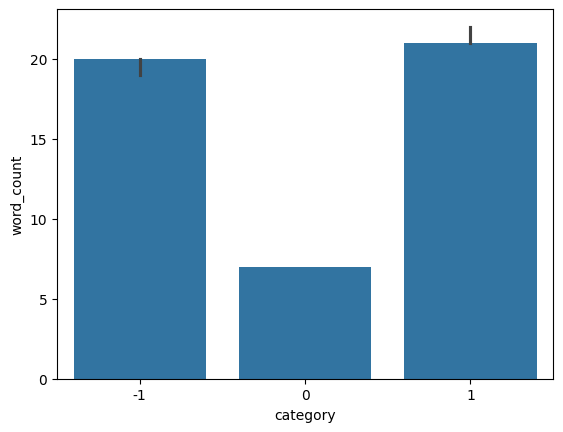

In [32]:
# median word counts among sentiments

sns.barplot(df,x='category',y='word_count',estimator='median')

In [33]:
!pip install nltk

In [34]:
from nltk.corpus import stopwords

# Download NLTK stopwords if not already downloaded
import nltk
nltk.download('stopwords')

# Define the list of English stopwords
stop_words = set(stopwords.words('english'))

# Create a new column 'num_stop_words' by counting the number of stopwords in each comment
df['num_stop_words'] = df['clean_comment'].apply(lambda x: len([word for word in x.split() if word in stop_words]))


[nltk_data] Downloading package stopwords to /Users/manel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
df.sample(5)

clean_comment  category  \
32329  thoughtful post which aspects you feel aren li...         1   
31458                                    copypasta sauce         0   
36719                    will destroy all kanoon dalaals        -1   
5642   wonder modi silent this brutal killing bharat ...        -1   
19526  just wanted say one bhakt friends from maheshw...         1   

       word_count  num_stop_words  
32329          12               5  
31458           2               0  
36719           5               2  
5642           17               3  
19526          60              21

/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)


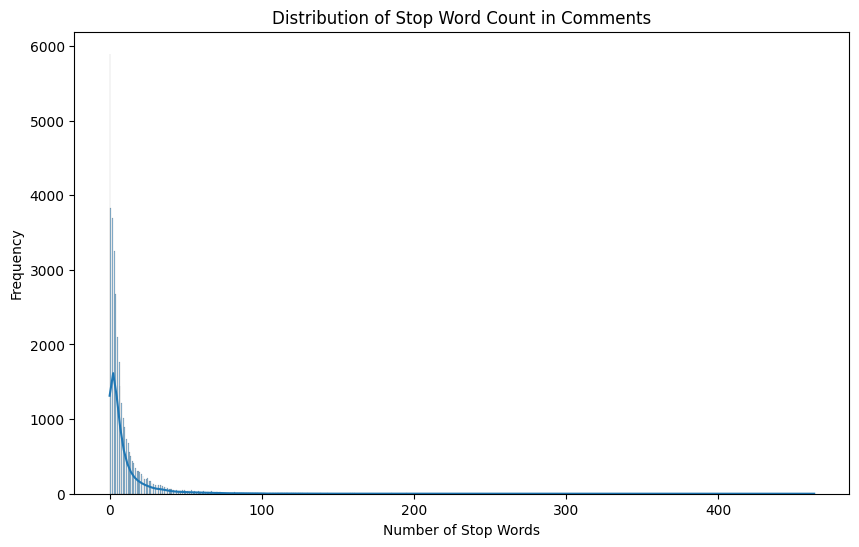

In [36]:
# Create a distribution plot (displot) for the 'num_stop_words' column
plt.figure(figsize=(10, 6))
sns.histplot(df['num_stop_words'], kde=True)
plt.title('Distribution of Stop Word Count in Comments')
plt.xlabel('Number of Stop Words')
plt.ylabel('Frequency')
plt.show()


/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/final/lib/python3.11/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x

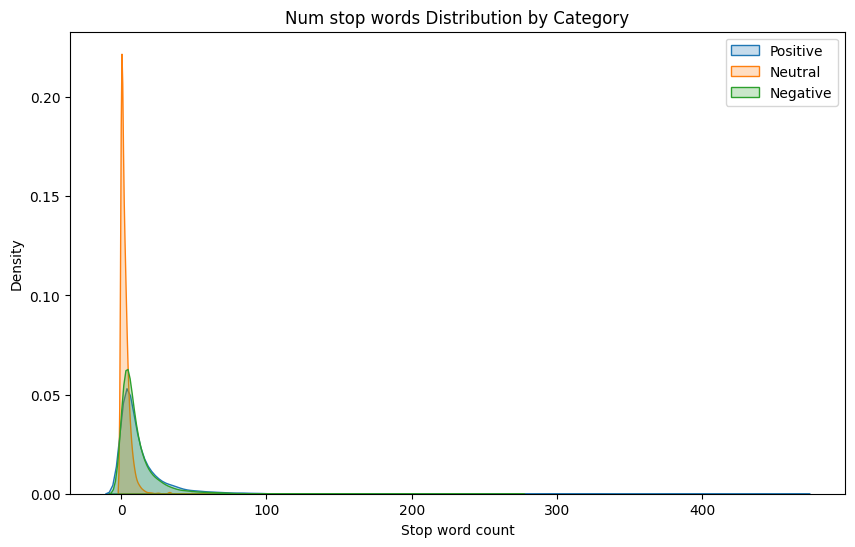

In [37]:
# Create the figure and axes
plt.figure(figsize=(10, 6))

# Plot KDE for category 1
sns.kdeplot(df[df['category'] == 1]['num_stop_words'], label='Positive', fill=True)

# Plot KDE for category 0
sns.kdeplot(df[df['category'] == 0]['num_stop_words'], label='Neutral', fill=True)

# Plot KDE for category -1
sns.kdeplot(df[df['category'] == -1]['num_stop_words'], label='Negative', fill=True)

# Add title and labels
plt.title('Num stop words Distribution by Category')
plt.xlabel('Stop word count')
plt.ylabel('Density')

# Add a legend
plt.legend()

# Show the plot
plt.show()

<Axes: xlabel='category', ylabel='num_stop_words'>

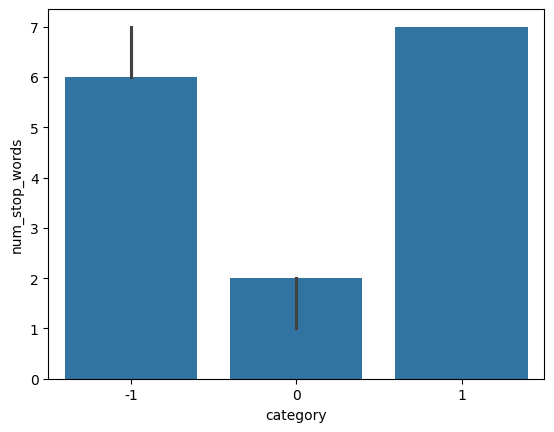

In [38]:
# median word counts among sentiments

sns.barplot(df,x='category',y='num_stop_words',estimator='median')

/var/folders/y9/33p0s2xs1pgb2ynmxl50fyc40000gn/T/ipykernel_80837/706517223.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_df, x='count', y='stop_word', palette='viridis')


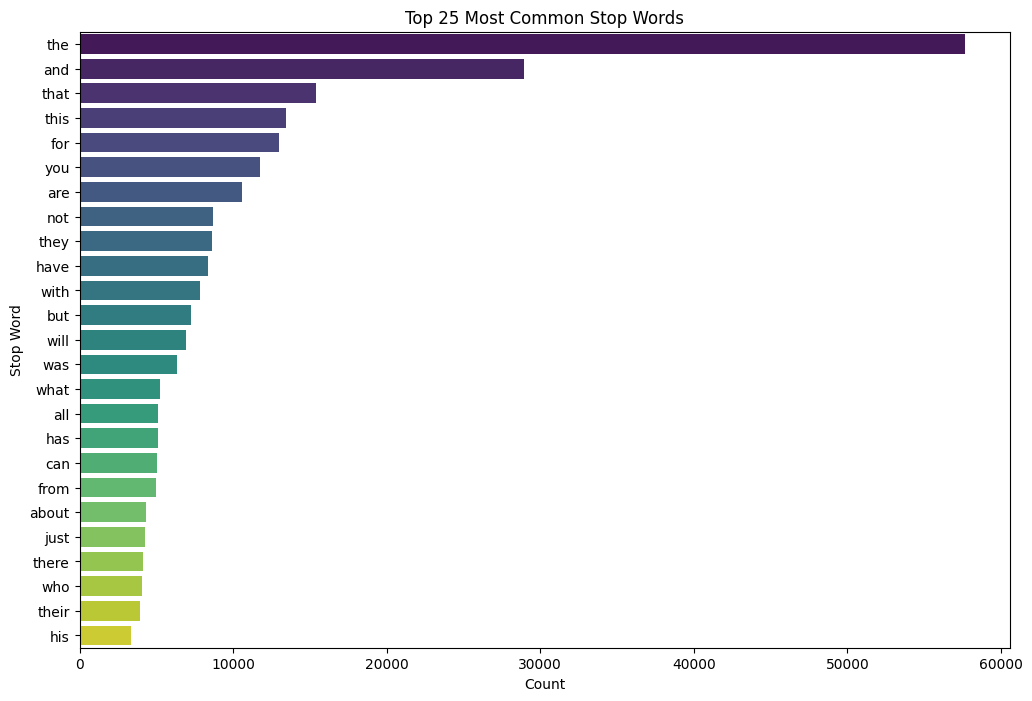

In [39]:
# Create a frequency distribution of stop words in the 'clean_comment' column
from collections import Counter

# Extract all stop words from the comments using the previously defined 'common_stopwords'
all_stop_words = [word for comment in df['clean_comment'] for word in comment.split() if word in stop_words]

# Count the most common stop words
most_common_stop_words = Counter(all_stop_words).most_common(25)

# Convert the most common stop words to a DataFrame for plotting
top_25_df = pd.DataFrame(most_common_stop_words, columns=['stop_word', 'count'])

# Create the barplot for the top 25 most common stop words
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_df, x='count', y='stop_word', palette='viridis')
plt.title('Top 25 Most Common Stop Words')
plt.xlabel('Count')
plt.ylabel('Stop Word')
plt.show()



In [40]:
df['num_chars'] = df['clean_comment'].apply(len)

df.head()

clean_comment  category  word_count  \
0  family mormon have never tried explain them th...         1          39   
1  buddhism has very much lot compatible with chr...         1         196   
2  seriously don say thing first all they won get...        -1          86   
3  what you have learned yours and only yours wha...         0          29   
4  for your own benefit you may want read living ...         1         112   

   num_stop_words  num_chars  
0              13        259  
1              59       1268  
2              40        459  
3              15        167  
4              45        690

In [41]:
df['num_chars'].describe()

count    36793.000000
mean       181.852798
std        359.702163
min          1.000000
25%         38.000000
50%         80.000000
75%        184.000000
max       8664.000000
Name: num_chars, dtype: float64

In [42]:
from collections import Counter

# Combine all comments into one large string
all_text = ' '.join(df['clean_comment'])

# Count the frequency of each character
char_frequency = Counter(all_text)

# Convert the character frequency into a DataFrame for better display
char_frequency_df = pd.DataFrame(char_frequency.items(), columns=['character', 'frequency']).sort_values(by='frequency', ascending=False)



In [43]:
char_frequency_df['character'].values

array([' ', 'e', 't', ..., '援', '哭', '悼'], dtype=object)

In [44]:
char_frequency_df.tail(50)

character  frequency
419          ൾ          1
973          挂          1
421          സ          1
970          荷          1
429          ശ          1
430          ൻ          1
967          满          1
965          需          1
434          œ          1
612          症          1
962          虑          1
961          考          1
960          梦          1
959          呆          1
786          示          1
992          魄          1
993          散          1
393          ◣          1
1012         丶          1
1026         龙          1
1025         将          1
635          悟          1
1023         近          1
363          ص          1
364          ح          1
1020         雪          1
1019         随          1
1018         留          1
1017         此          1
365          ط          1
776          坚          1
1014         照          1
1013         按          1
381          ☐          1
995          理          1
383          ̄          1
1009         右          1
1008         左          1
778          取          1
1005         殴          1
1004         滴          1
779          己          1
1002         记          1
628          帮          1
1000         仇          1
999          丢          1
392          ͞          1
997          援          1
996          哭          1
1095         悼          1

In [45]:
# Create a new column 'num_punctuation_chars' to count punctuation characters in each comment
df['num_punctuation_chars'] = df['clean_comment'].apply(
    lambda x: sum([1 for char in x if char in '.,!?;:"\'()[]{}-'])
)

df.sample(5)

clean_comment  category  \
3480                       did you factor recession 2008         0   
16122  how many bakris have you fucked you kill them ...        -1   
13938                                      the beautiful         1   
7903   omar mateen identified the gunman who killed a...         1   
7075   ravish kumar िटलर ि् ‘िटलर’ ें ीं ोा ै hitler ...         1   

       word_count  num_stop_words  num_chars  num_punctuation_chars  
3480            5               2         29                      0  
16122          19               9         97                      0  
13938           2               1         13                      0  
7903           84              21        523                      0  
7075           45              15        268                      0

In [46]:
df['num_punctuation_chars'].describe()

count    36793.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: num_punctuation_chars, dtype: float64

/var/folders/y9/33p0s2xs1pgb2ynmxl50fyc40000gn/T/ipykernel_80837/1638384091.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_bigrams_df, x='count', y='bigram', palette='magma')


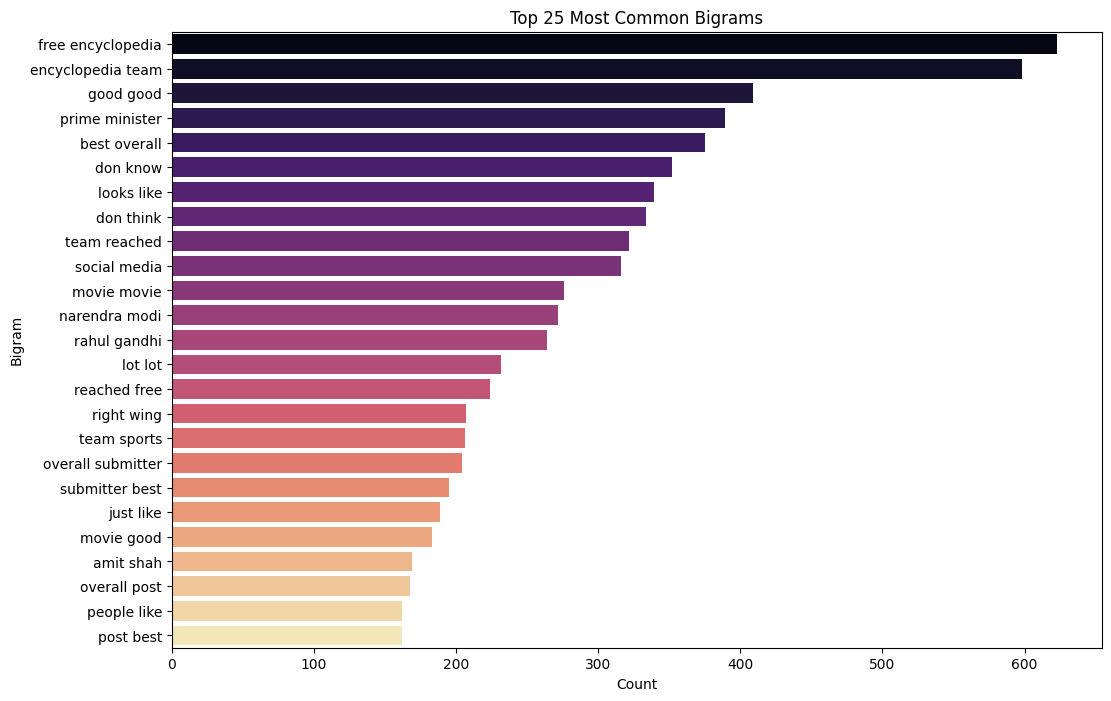

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a function to extract the top 25 bigrams
def get_top_ngrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get the top 25 bigrams
top_25_bigrams = get_top_ngrams(df['clean_comment'], 25)

# Convert the bigrams into a DataFrame for plotting
top_25_bigrams_df = pd.DataFrame(top_25_bigrams, columns=['bigram', 'count'])

# Plot the countplot for the top 25 bigrams
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_bigrams_df, x='count', y='bigram', palette='magma')
plt.title('Top 25 Most Common Bigrams')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.show()


/var/folders/y9/33p0s2xs1pgb2ynmxl50fyc40000gn/T/ipykernel_80837/2492861520.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_trigrams_df, x='count', y='trigram', palette='coolwarm')


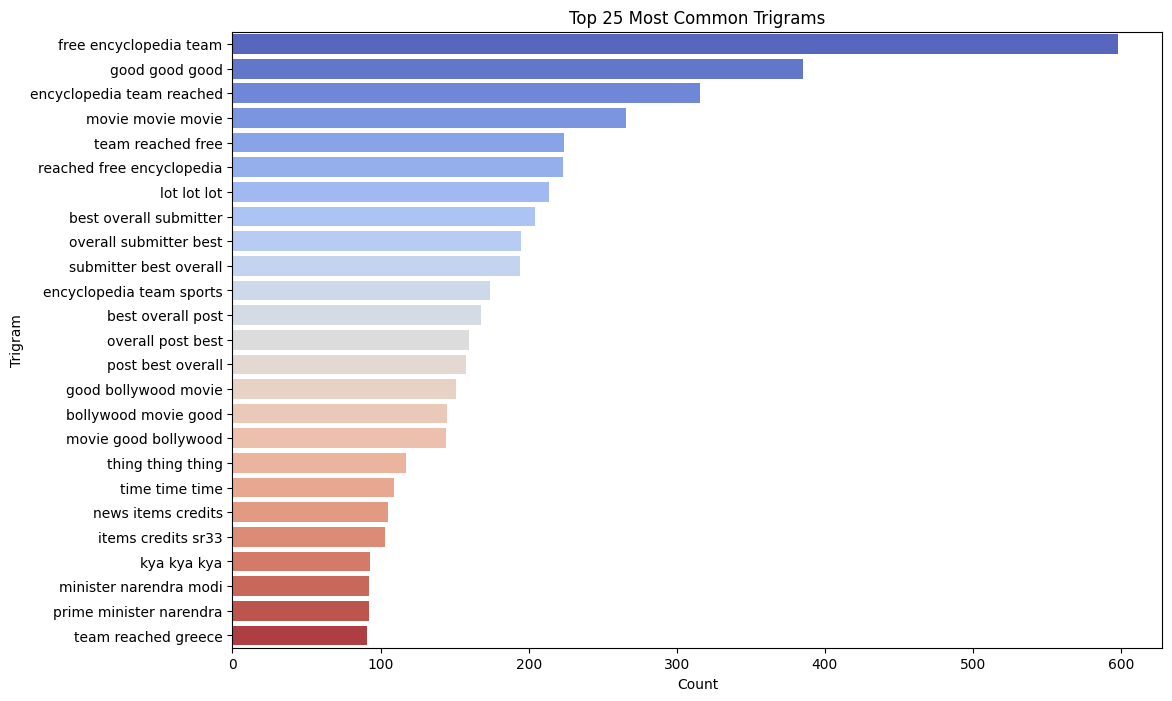

In [48]:
# Create a function to extract the top 25 trigrams
def get_top_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get the top 25 trigrams
top_25_trigrams = get_top_trigrams(df['clean_comment'], 25)

# Convert the trigrams into a DataFrame for plotting
top_25_trigrams_df = pd.DataFrame(top_25_trigrams, columns=['trigram', 'count'])

# Plot the countplot for the top 25 trigrams
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_trigrams_df, x='count', y='trigram', palette='coolwarm')
plt.title('Top 25 Most Common Trigrams')
plt.xlabel('Count')
plt.ylabel('Trigram')
plt.show()

In [49]:
# Remove non-English characters from the 'clean_comment' column
# Keeping only standard English letters, digits, and common punctuation
import re

df['clean_comment'] = df['clean_comment'].apply(lambda x: re.sub(r'[^A-Za-z0-9\s!?.,]', '', str(x)))


In [50]:
all_text = ' '.join(df['clean_comment'])

# Count the frequency of each character
char_frequency = Counter(all_text)

# Convert the character frequency into a DataFrame for better display
char_frequency_df = pd.DataFrame(char_frequency.items(), columns=['character', 'frequency']).sort_values(by='frequency', ascending=False)

char_frequency_df

character  frequency
6               1091592
12         e     666610
13         t     491287
1          a     481134
3          i     401388
9          n     388465
7          o     379908
17         s     355279
8          r     331425
10         h     296748
4          l     250104
14         d     221980
18         u     170377
22         c     167821
2          m     155561
16         p     135139
21         g     132927
5          y     115420
25         w     110522
24         b      88199
0          f      78866
11         v      66020
20         k      62531
26         j      22906
15         x       9075
30         0       8477
19         z       5725
23         q       5136
31         1       4845
32         2       4638
34         9       1775
27         5       1631
35         3       1617
29         4       1573
28         6       1403
36         7       1291
33         8       1199
38                   76
37        \t         11
40                    3
39                    1

In [51]:
df.head()

clean_comment  category  word_count  \
0  family mormon have never tried explain them th...         1          39   
1  buddhism has very much lot compatible with chr...         1         196   
2  seriously don say thing first all they won get...        -1          86   
3  what you have learned yours and only yours wha...         0          29   
4  for your own benefit you may want read living ...         1         112   

   num_stop_words  num_chars  num_punctuation_chars  
0              13        259                      0  
1              59       1268                      0  
2              40        459                      0  
3              15        167                      0  
4              45        690                      0

In [52]:
from nltk.corpus import stopwords

# Defining stop words but keeping essential ones for sentiment analysis
stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}

# Remove stop words from 'clean_comment' column, retaining essential ones
df['clean_comment'] = df['clean_comment'].apply(
    lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words])
)




In [53]:
df.head()

clean_comment  category  word_count  \
0  family mormon never tried explain still stare ...         1          39   
1  buddhism much lot compatible christianity espe...         1         196   
2  seriously say thing first get complex explain ...        -1          86   
3  learned want teach different focus goal not wr...         0          29   
4  benefit may want read living buddha living chr...         1         112   

   num_stop_words  num_chars  num_punctuation_chars  
0              13        259                      0  
1              59       1268                      0  
2              40        459                      0  
3              15        167                      0  
4              45        690                      0

In [54]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

# Define the lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization to the 'clean_comment_no_stopwords' column
df['clean_comment'] = df['clean_comment'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
)

df.head()

[nltk_data] Downloading package wordnet to /Users/manel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


clean_comment  category  word_count  \
0  family mormon never tried explain still stare ...         1          39   
1  buddhism much lot compatible christianity espe...         1         196   
2  seriously say thing first get complex explain ...        -1          86   
3  learned want teach different focus goal not wr...         0          29   
4  benefit may want read living buddha living chr...         1         112   

   num_stop_words  num_chars  num_punctuation_chars  
0              13        259                      0  
1              59       1268                      0  
2              40        459                      0  
3              15        167                      0  
4              45        690                      0

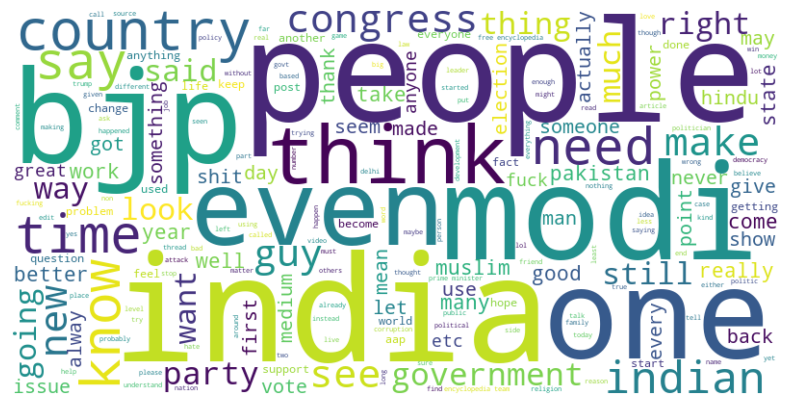

In [55]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

plot_word_cloud(df['clean_comment'])

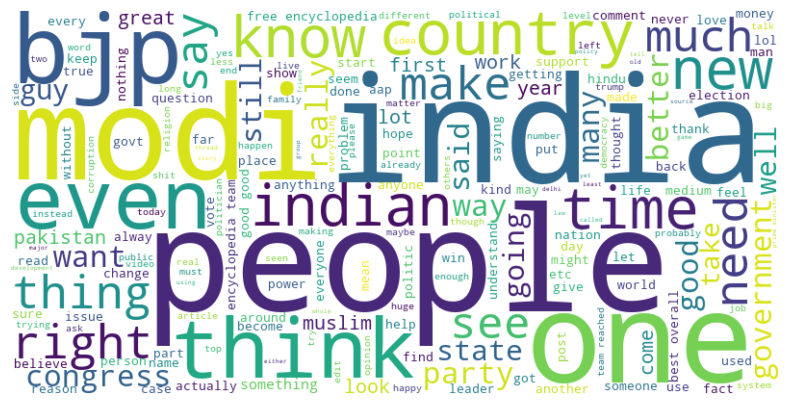

In [56]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

plot_word_cloud(df[df['category'] == 1]['clean_comment'])

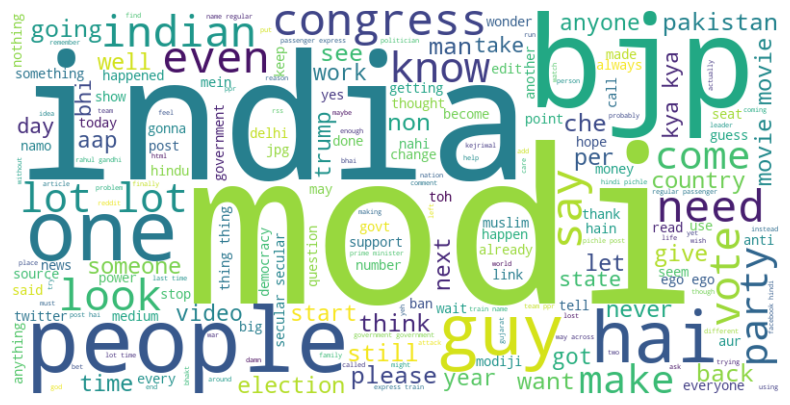

In [57]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

plot_word_cloud(df[df['category'] == 0]['clean_comment'])

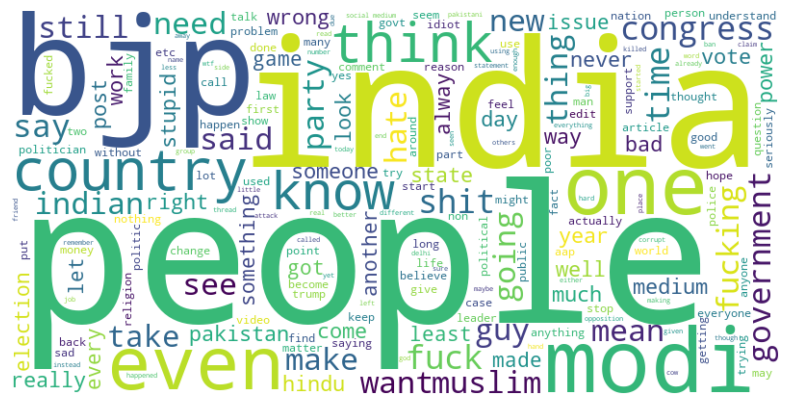

In [58]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

plot_word_cloud(df[df['category'] == -1]['clean_comment'])

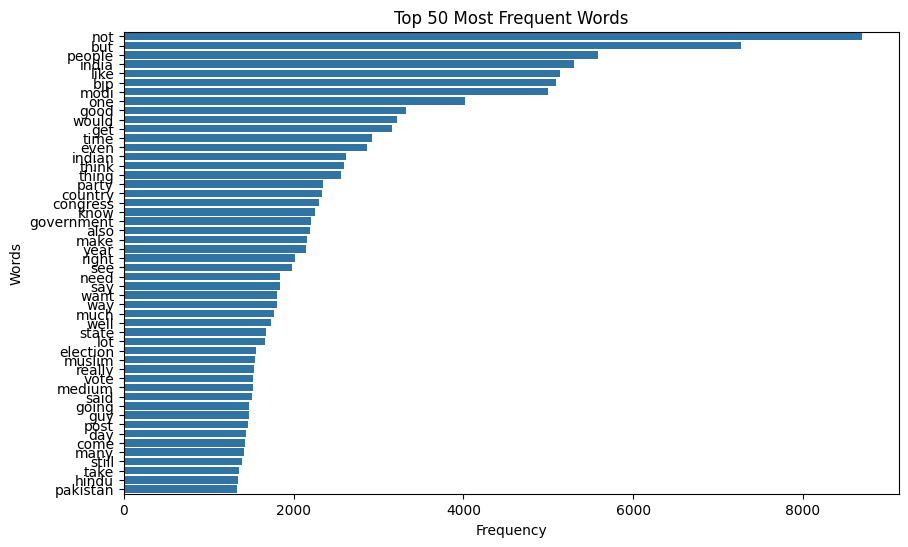

In [59]:
def plot_top_n_words(df, n=20):
    """Plot the top N most frequent words in the dataset."""
    # Flatten all words in the content column
    words = ' '.join(df['clean_comment']).split()

    # Get the top N most common words
    counter = Counter(words)
    most_common_words = counter.most_common(n)

    # Split the words and their counts for plotting
    words, counts = zip(*most_common_words)

    # Plot the top N words
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f'Top {n} Most Frequent Words')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

# Example usage
plot_top_n_words(df, n=50)


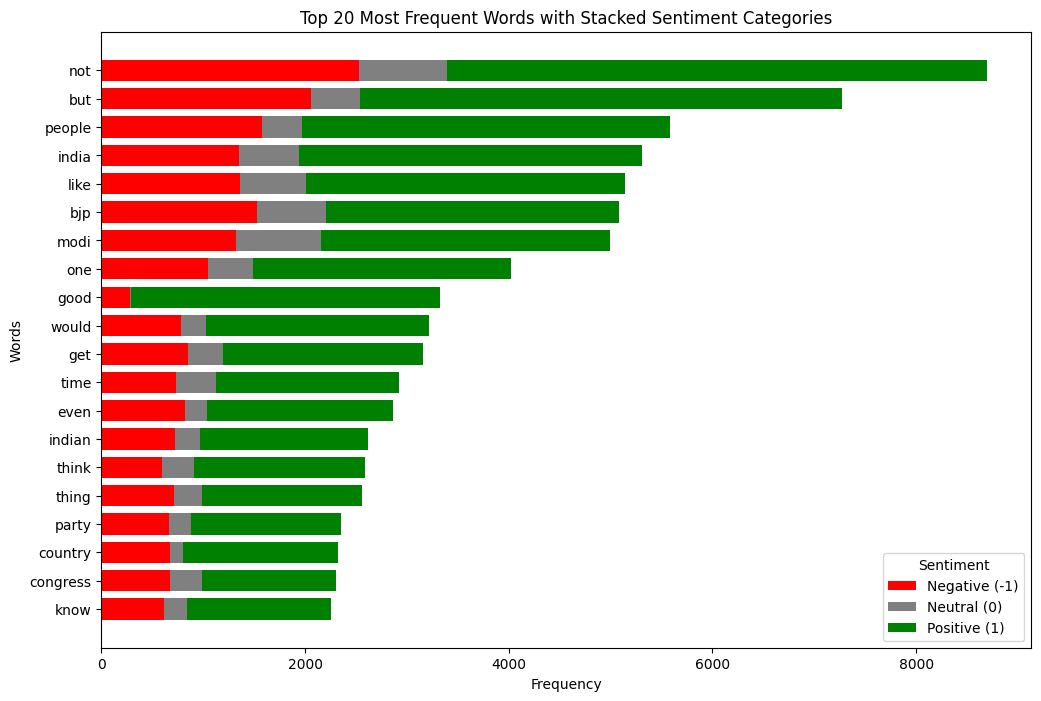

In [60]:
def plot_top_n_words_by_category(df, n=20, start=0):
    """Plot the top N most frequent words in the dataset with stacked hue based on sentiment category."""
    # Flatten all words in the content column and count their occurrences by category
    word_category_counts = {}

    for idx, row in df.iterrows():
        words = row['clean_comment'].split()
        category = row['category']  # Assuming 'category' column exists for -1, 0, 1 labels

        for word in words:
            if word not in word_category_counts:
                word_category_counts[word] = { -1: 0, 0: 0, 1: 0 }  # Initialize counts for each sentiment category

            # Increment the count for the corresponding sentiment category
            word_category_counts[word][category] += 1

    # Get total counts across all categories for each word
    total_word_counts = {word: sum(counts.values()) for word, counts in word_category_counts.items()}

    # Get the top N most frequent words across all categories
    most_common_words = sorted(total_word_counts.items(), key=lambda x: x[1], reverse=True)[start:start+n]
    top_words = [word for word, _ in most_common_words]

    # Prepare data for plotting
    word_labels = top_words
    negative_counts = [word_category_counts[word][-1] for word in top_words]
    neutral_counts = [word_category_counts[word][0] for word in top_words]
    positive_counts = [word_category_counts[word][1] for word in top_words]

    # Plot the stacked bar chart
    plt.figure(figsize=(12, 8))
    bar_width = 0.75

    # Plot negative, neutral, and positive counts in a stacked manner
    plt.barh(word_labels, negative_counts, color='red', label='Negative (-1)', height=bar_width)
    plt.barh(word_labels, neutral_counts, left=negative_counts, color='gray', label='Neutral (0)', height=bar_width)
    plt.barh(word_labels, positive_counts, left=[i+j for i,j in zip(negative_counts, neutral_counts)], color='green', label='Positive (1)', height=bar_width)

    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top {n} Most Frequent Words with Stacked Sentiment Categories')
    plt.legend(title='Sentiment', loc='lower right')
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest frequency at the top
    plt.show()



plot_top_n_words_by_category(df, n=20)


# 🚀 Version améliorée / nettoyage du code


In [ ]:
# ============================================
# YouTube / Reddit Sentiment Analysis
# Pré-traitement & Exploration des données (EDA)
# ============================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import os
import logging

# --------------------------
# 0️⃣ Logging
# --------------------------
logger = logging.getLogger('EDA')
logger.setLevel(logging.DEBUG)
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

# --------------------------
# 1️⃣ Créer dossier reports
# --------------------------
os.makedirs("reports", exist_ok=True)

# --------------------------
# 2️⃣ Charger le dataset
# --------------------------
df = pd.read_csv(
    'https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv'
)
logger.info(f"Dataset loaded with shape {df.shape}")

# Aperçu des données
display(df.head())
df.info()
print("Valeurs nulles par colonne :\n", df.isnull().sum())

# --------------------------
# 3️⃣ Nettoyage des données
# --------------------------
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df = df[~(df['clean_comment'].str.strip() == '')]

df['clean_comment'] = df['clean_comment'].str.lower().str.strip()
df['clean_comment'] = df['clean_comment'].str.replace('\n', ' ', regex=True)
df['clean_comment'] = df['clean_comment'].apply(lambda x: re.sub(r'[^A-Za-z0-9\s!?.,]', '', str(x)))

logger.info(f"Data cleaned. Shape after cleaning: {df.shape}")

# --------------------------
# 4️⃣ Analyse exploratoire (EDA)
# --------------------------
# Distribution des catégories
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='category')
plt.title("Distribution des catégories de sentiments")
plt.savefig("reports/category_distribution.png")
plt.show()

# Nombre de mots par commentaire
df['word_count'] = df['clean_comment'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,6))
sns.histplot(df['word_count'], kde=True)
plt.title("Distribution du nombre de mots par commentaire")
plt.savefig("reports/word_count_distribution.png")
plt.show()

# Boxplot et KDE par catégorie
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='category', y='word_count')
plt.title("Boxplot du nombre de mots par catégorie")
plt.savefig("reports/word_count_boxplot.png")
plt.show()

plt.figure(figsize=(10,6))
for cat, color in zip([-1,0,1], ['red','gray','green']):
    sns.kdeplot(df[df['category']==cat]['word_count'], label=f"Category {cat}", fill=True)
plt.title("KDE du nombre de mots par catégorie")
plt.savefig("reports/word_count_kde.png")
plt.show()

# --------------------------
# 5️⃣ Stopwords
# --------------------------
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
df['num_stop_words'] = df['clean_comment'].apply(lambda x: len([w for w in x.split() if w in stop_words]))

plt.figure(figsize=(10,6))
sns.histplot(df['num_stop_words'], kde=True)
plt.title("Distribution du nombre de stop words")
plt.savefig("reports/stopwords_distribution.png")
plt.show()

# --------------------------
# 6️⃣ Nettoyage des stopwords et lemmatisation
# --------------------------
df['clean_comment'] = df['clean_comment'].apply(lambda x: ' '.join([w for w in x.split() if w not in stop_words]))

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
df['clean_comment'] = df['clean_comment'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in x.split()]))

logger.info("Stopwords removed and lemmatization done.")

# --------------------------
# 7️⃣ WordCloud
# --------------------------
def plot_word_cloud(text, title, file_name):
    wc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.savefig(f"reports/{file_name}.png")
    plt.show()

plot_word_cloud(df['clean_comment'], "WordCloud global", "wordcloud_global")
plot_word_cloud(df[df['category']==1]['clean_comment'], "Positifs", "wordcloud_positive")
plot_word_cloud(df[df['category']==0]['clean_comment'], "Neutres", "wordcloud_neutral")
plot_word_cloud(df[df['category']==-1]['clean_comment'], "Negatifs", "wordcloud_negative")

# --------------------------
# 8️⃣ Top N ngrams
# --------------------------
def get_top_ngrams(corpus, n=25, ngram_range=(2,2)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag = vec.transform(corpus)
    sum_words = bag.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x:x[1], reverse=True)[:n]

top_bigrams = pd.DataFrame(get_top_ngrams(df['clean_comment'], 25, (2,2)), columns=['bigram','count'])
plt.figure(figsize=(12,8))
sns.barplot(data=top_bigrams, x='count', y='bigram', palette='magma')
plt.title("Top 25 Bigrams")
plt.savefig("reports/top_bigrams.png")
plt.show()

top_trigrams = pd.DataFrame(get_top_ngrams(df['clean_comment'], 25, (3,3)), columns=['trigram','count'])
plt.figure(figsize=(12,8))
sns.barplot(data=top_trigrams, x='count', y='trigram', palette='coolwarm')
plt.title("Top 25 Trigrams")
plt.savefig("reports/top_trigrams.png")
plt.show()

# --------------------------
# 9️⃣ Top mots par catégorie
# --------------------------
def plot_top_words_by_category(df, n=20):
    word_cat = {}
    for _, row in df.iterrows():
        cat = row['category']
        for w in row['clean_comment'].split():
            word_cat.setdefault(w, {-1:0,0:0,1:0})
            word_cat[w][cat] += 1
    total_counts = {w: sum(c.values()) for w,c in word_cat.items()}
    top_words = sorted(total_counts.items(), key=lambda x:x[1], reverse=True)[:n]
    words = [w for w,_ in top_words]
    neg_counts = [word_cat[w][-1] for w in words]
    neu_counts = [word_cat[w][0] for w in words]
    pos_counts = [word_cat[w][1] for w in words]

    plt.figure(figsize=(12,8))
    bar_width = 0.75
    plt.barh(words, neg_counts, color='red', height=bar_width)
    plt.barh(words, neu_counts, left=neg_counts, color='gray', height=bar_width)
    plt.barh(words, pos_counts, left=[i+j for i,j in zip(neg_counts, neu_counts)], color='green', height=bar_width)
    plt.xlabel("Fréquence")
    plt.title(f"Top {n} mots par catégorie")
    plt.legend(["Negatif","Neutre","Positif"])
    plt.gca().invert_yaxis()
    plt.savefig("reports/top_words_by_category.png")
    plt.show()

plot_top_words_by_category(df, n=20)

logger.info("EDA completed. All plots saved in 'reports/'")
